## Edge detection per color

In [3]:
# ==============================================================================
# CELL 1: PART 1 – Edge Detection per Color (Interactive)
# ==============================================================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import ipywidgets as widgets
from IPython.display import display, clear_output
from collections import defaultdict

In [11]:
# ==============================================================================
#  PART 1 – Mask‑based Contour Extraction (no Canny)
# ==============================================================================

import cv2, math, numpy as np, matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from collections import defaultdict

# ──────────────────────────────────────────────────────────────────────────────
# Global data holders
# ──────────────────────────────────────────────────────────────────────────────
loaded_image_data = {
    "original"        : None,
    "bgr_for_processing": None,   # 3‑channel BGR version
    "filename_base"   : None,
    "height"          : 0,
    "width"           : 0,
    "total_area"      : 0,
    "perimeter_ref"   : 0,
    "palette"         : None      # list of (B,G,R)
}
part1_results = {
    "contours_by_color": {},
    "combined_mask"    : None
}

# ──────────────────────────────────────────────────────────────────────────────
# Helper – load a default quantised image and palette
# ──────────────────────────────────────────────────────────────────────────────
def load_default_image(path="ppf_quant.png"):
    img = cv2.imread(path)
    if img is None:
        print(f"Could not load {path}")
        return

    palette = np.unique(img.reshape(-1, img.shape[-1]), axis=0).tolist()
    palette = [tuple(map(int, c)) for c in palette]

    loaded_image_data.update(
        original            = img,
        bgr_for_processing  = img[:, :, :3] if img.shape[2] == 4 else img,
        filename_base       = path.rsplit(".", 1)[0],
        palette             = palette,
        height              = img.shape[0],
        width               = img.shape[1],
        total_area          = float(img.shape[0] * img.shape[1]),
        perimeter_ref       = float(2 * (img.shape[0] + img.shape[1])),
    )
    print(f"Loaded {path}: {img.shape[1]}×{img.shape[0]}  "
          f"with {len(palette)} palette colours")

load_default_image()          # auto‑load on notebook start

# ──────────────────────────────────────────────────────────────────────────────
# Core – contour extraction per colour  (outer contours only)
# ──────────────────────────────────────────────────────────────────────────────
def find_contours_per_color(image_bgr, palette_colors,
                            use_morph_close, morph_ksize,
                            dedup_tau):
    h, w = image_bgr.shape[:2]
    contours_by_color = defaultdict(list)
    combined_mask     = np.zeros((h, w), np.uint8)
    img_mask          = image_bgr[:, :, :3] if image_bgr.shape[2] == 4 else image_bgr
    min_area_px       = 0.001 / 100 * (h * w)   # 0.001 % of image

    for colour in palette_colors:
        mask_bool = np.all(img_mask == np.array(colour, img_mask.dtype), axis=2)
        if not mask_bool.any():
            continue
        mask_u8 = (mask_bool.astype(np.uint8) * 255)

        # --- basic denoising ---------------------------------------------------
        mask_u8 = cv2.morphologyEx(mask_u8, cv2.MORPH_OPEN,
                                   cv2.getStructuringElement(cv2.MORPH_RECT, (3,3)))
        num, lbl, stats, _ = cv2.connectedComponentsWithStats(mask_u8)
        keep   = np.isin(lbl, np.where(stats[:,4] >= 0.15/100 * (h*w))[0])
        mask_u8 = (keep*255).astype(np.uint8)

        if use_morph_close and morph_ksize > 0:
            kernel  = cv2.getStructuringElement(cv2.MORPH_RECT, (morph_ksize, morph_ksize))
            mask_u8 = cv2.morphologyEx(mask_u8, cv2.MORPH_CLOSE, kernel)

        # -------- DISTINCT CLOSED ELEMENTS (outer boundaries) ------------------
        raw, _ = cv2.findContours(mask_u8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        raw    = [c for c in raw if cv2.contourArea(c) >= min_area_px]

        if raw:
            contours_by_color[colour].extend(raw)
            combined_mask = cv2.bitwise_or(combined_mask, mask_u8)

    # --- belt‑and‑suspenders cross‑colour dedup --------------------------------
    if dedup_tau > 0:
        pos_tol  = max(h, w) * 0.01
        area_tol = 0.10
        uniques, cleaned = [], defaultdict(list)

        def centroid(cnt):
            m = cv2.moments(cnt)
            return np.array([m["m10"], m["m01"]]) / max(m["m00"], 1e-6)

        for col, cnts in contours_by_color.items():
            for c in cnts:
                keep = True
                c_area, c_cent = cv2.contourArea(c), centroid(c)
                for u in uniques:
                    if cv2.matchShapes(c, u, cv2.CONTOURS_MATCH_I1, 0) < dedup_tau:
                        u_area, u_cent = cv2.contourArea(u), centroid(u)
                        if (np.linalg.norm(c_cent - u_cent) <= pos_tol and
                            abs(c_area - u_area)/max(c_area,u_area) <= area_tol):
                            keep = False
                            break
                if keep:
                    uniques.append(c)
                    cleaned[col].append(c)
        contours_by_color = cleaned
    # --------------------------------------------------------------------------
    return contours_by_color, combined_mask

# ──────────────────────────────────────────────────────────────────────────────
# Visualisation  – gallery + hierarchy‑aware reconstruction
# ──────────────────────────────────────────────────────────────────────────────
def display_contours_per_color(contours_by_color, height, width, palette,
                               thumbs_per_row=6, thumb_scale=0.20):
    if not contours_by_color:
        print("No contours found."); return

    img_bgr = loaded_image_data["bgr_for_processing"]
    thumb_w, thumb_h = int(width*thumb_scale), int(height*thumb_scale)

    tiles, combined_outline = [], np.full_like(img_bgr, 255)
    reconstructed          = np.full_like(img_bgr, 255)

    for colour in palette:
        if colour not in contours_by_color:  # skip colours with no elements
            continue

        # mask thumbnail
        mask = (np.all(img_bgr == np.array(colour, img_bgr.dtype), 2)*255).astype(np.uint8)
        tiles.append((f"Mask {tuple(reversed(colour))}",
                      cv2.resize(mask, (thumb_w, thumb_h), cv2.INTER_NEAREST)))

        # contour thumbnail (outer contours only)
        canvas = np.full((height, width, 3), 255, np.uint8)
        cv2.drawContours(canvas, contours_by_color[colour], -1,
                         tuple(int(c) for c in colour), 1)
        cv2.drawContours(combined_outline, contours_by_color[colour], -1,
                         tuple(int(c) for c in colour), 1)
        tiles.append((f"Contours ({len(contours_by_color[colour])})",
                      cv2.resize(canvas, (thumb_w, thumb_h), cv2.INTER_AREA)))

        # hierarchy‑aware fill for reconstruction
        mask_u8 = mask.copy()
        cnts, hier = cv2.findContours(mask_u8, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        if hier is None: continue
        for i, h in enumerate(hier[0]):
            if h[3] == -1:   # only outer contour
                cv2.drawContours(reconstructed, cnts, i,
                                 tuple(int(c) for c in colour), cv2.FILLED)

    # thumbnail grid
    cols = thumbs_per_row; rows = math.ceil(len(tiles)/cols)
    plt.figure(figsize=(cols*2, rows*2))
    for idx, (title, img) in enumerate(tiles, 1):
        plt.subplot(rows, cols, idx)
        if img.ndim == 2: plt.imshow(img, cmap="gray")
        else:             plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title, fontsize=6); plt.axis("off")
    plt.tight_layout(); plt.show()

    # combined outline
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(combined_outline, cv2.COLOR_BGR2RGB))
    plt.title("All Coloured Contours (outline)"); plt.axis("off"); plt.show()

    # reconstructed (filled) image
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(reconstructed, cv2.COLOR_BGR2RGB))
    plt.title("Reconstructed Image (filled)"); plt.axis("off"); plt.show()

    part1_results["reconstructed"] = reconstructed


# ──────────────────────────────────────────────────────────────────────────────
# Interactive controls (only ones we still use)
# ──────────────────────────────────────────────────────────────────────────────
w_use_morph_close = widgets.Checkbox(value=True,  description="Morph Close")
w_morph_ksize     = widgets.IntSlider(value=3, min=1, max=15, step=2,
                                      description="Kernel", continuous_update=False)
w_dedup_tau       = widgets.FloatSlider(value=0.0, min=0.0, max=1.0, step=0.01,
                                        description="Dedup τ", continuous_update=False)

def update_part1(use_morph_close, morph_ksize, dedup_tau):
    clear_output(wait=True)
    if loaded_image_data["original"] is None:
        print("Load an image first."); return
    img   = loaded_image_data["bgr_for_processing"]
    pal   = loaded_image_data["palette"]
    h, w  = loaded_image_data["height"], loaded_image_data["width"]

    cnts_by_col, comb_mask = find_contours_per_color(
        img, pal, use_morph_close, morph_ksize, dedup_tau)

    part1_results.update(contours_by_color=cnts_by_col, combined_mask=comb_mask)
    display_contours_per_color(cnts_by_col, h, w, pal)
    print("\nPart 1 complete – proceed to Part 2 if desired.")

controls = widgets.VBox([w_use_morph_close, w_morph_ksize, w_dedup_tau])
out      = widgets.interactive_output(update_part1,
              dict(use_morph_close=w_use_morph_close,
                   morph_ksize    =w_morph_ksize,
                   dedup_tau      =w_dedup_tau))
display(widgets.HTML("<h3>Part 1 – Mask‑based Contours</h3>"), controls, out)


Loaded ppf_quant.png: 340×611  with 8 palette colours


HTML(value='<h3>Part\u202f1 – Mask‑based Contours</h3>')

Output()

## Process and Filter Combined Contours

In [108]:
# ==============================================================================
# CELL 2: PART 2 – Processing and Filtering Combined Contours (Interactive)
# ==============================================================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import ipywidgets as widgets
from IPython.display import display, clear_output

# Global dictionary to store Part 2 results.
part2_results = {}


# ----- Part 2 Functions -----
def filter_contours_by_criteria(contours, min_pixel_area, max_pixel_area,
                                min_pixel_perimeter, max_pixel_perimeter, min_circularity):
    if not contours:
        return []
    filtered = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if not (min_pixel_area <= area <= max_pixel_area):
            continue
        perimeter = cv2.arcLength(cnt, True)
        if perimeter == 0:
            continue
        if not (min_pixel_perimeter <= perimeter <= max_pixel_perimeter):
            continue
        circularity = (4 * np.pi * area) / (perimeter * perimeter) if perimeter > 0 else 0
        if circularity < min_circularity:
            continue
        filtered.append(cnt)
    return filtered

def process_and_filter_contours(contours_by_color, similarity_thresh, approx_eps_factor,
                                area_range_percent, perimeter_range_percent, min_circularity,
                                total_area, perimeter_ref, include_border, height, width):
    print("\n--- Part 2: Processing and Filtering ---")
    # Combine contours from all colors.
    all_raw_contours = []
    for cnts in contours_by_color.values():
        all_raw_contours.extend(cnts)
    if not all_raw_contours:
        print("No contours available from Part 1.")
        return [], []
    print(f"Processing {len(all_raw_contours)} raw contours...")
    # Deduplicate contours.
    unique_contours = []
    all_raw_contours.sort(key=cv2.contourArea, reverse=True)
    for cnt in all_raw_contours:
        is_unique = True
        for kept in unique_contours:
            score = cv2.matchShapes(cnt, kept, cv2.CONTOURS_MATCH_I1, 0.0)
            if score < similarity_thresh:
                is_unique = False
                break
        if is_unique:
            unique_contours.append(cnt)
    print(f"Deduplicated to {len(unique_contours)} contours.")
    # Apply contour approximation.
    approximated_contours = []
    if approx_eps_factor > 0:
        for cnt in unique_contours:
            peri = cv2.arcLength(cnt, True)
            epsilon = (approx_eps_factor / 10) * peri
            approx = cv2.approxPolyDP(cnt, epsilon, True)
            approximated_contours.append(approx)
    else:
        approximated_contours = unique_contours
    print(f"After approximation: {len(approximated_contours)} contours.")
    # Compute filtering thresholds.
    min_area_p, max_area_p = area_range_percent
    min_perim_p, max_perim_p = perimeter_range_percent
    min_pixel_area = (min_area_p / 10000.0) * total_area
    max_pixel_area = (max_area_p / 10000.0) * total_area
    min_pixel_perimeter = (min_perim_p / 100.0) * perimeter_ref
    max_pixel_perimeter = (max_perim_p / 100.0) * perimeter_ref
    print(f"Filter thresholds: Area [{min_pixel_area:.1f}, {max_pixel_area:.1f}], Perimeter [{min_pixel_perimeter:.1f}, {max_pixel_perimeter:.1f}], MinCirc {min_circularity:.2f}")
    # Filter contours.
    filtered_contours = filter_contours_by_criteria(approximated_contours,
                                                      min_pixel_area, max_pixel_area,
                                                      min_pixel_perimeter, max_pixel_perimeter,
                                                      min_circularity)
    print(f"Filtered down to {len(filtered_contours)} contours.")
    # Optionally add image border.
    if include_border:
        border = np.array([[[0, 0]], [[width-1, 0]], [[width-1, height-1]], [[0, height-1]]], dtype=np.int32)
        filtered_contours.append(border)
        print("Added image border as a contour.")
    print("--- Part 2 Complete ---")
    return approximated_contours, filtered_contours

def visualize_final_results(original_image, combined_edge_map, all_processed_contours, filtered_contours):
    if len(original_image.shape) == 2:
        disp_img = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)
    elif original_image.shape[2] == 4:
        disp_img = original_image[:, :, :3].copy()
    else:
        disp_img = original_image.copy()
    canvas_all = np.full_like(disp_img, 255)
    canvas_filtered = np.full_like(disp_img, 255)
    cv2.drawContours(canvas_all, all_processed_contours, -1, (0, 0, 0), 1)
    cv2.drawContours(canvas_filtered, filtered_contours, -1, (0, 0, 0), 1)
    plt.figure(figsize=(10, 8))
    plt.suptitle("Part 2: Combined & Filtered Contours", fontsize=14)
    plt.subplot(2, 2, 1)
    if len(original_image.shape) == 2:
        plt.imshow(original_image, cmap='gray')
        plt.title("Original Grayscale")
    elif original_image.shape[2] == 4:
        plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGRA2RGB))
        plt.title("Original BGRA")
    else:
        plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        plt.title("Original BGR")
    plt.axis('off')
    plt.subplot(2, 2, 2)
    plt.imshow(combined_edge_map, cmap='gray')
    plt.title("Combined Edge Map")
    plt.axis('off')
    plt.subplot(2, 2, 3)
    plt.imshow(cv2.cvtColor(canvas_all, cv2.COLOR_BGR2RGB))
    plt.title(f"All Processed Contours ({len(all_processed_contours)})")
    plt.axis('off')
    plt.subplot(2, 2, 4)
    plt.imshow(cv2.cvtColor(canvas_filtered, cv2.COLOR_BGR2RGB))
    plt.title(f"Filtered Contours ({len(filtered_contours)})")
    plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ----- Interactive Part 2 Widgets -----
w_similarity_threshold = widgets.FloatSlider(value=0.20, min=0.00, max=1.00, step=0.01,
                                               description='Dedup Thresh:', continuous_update=False)
w_eps_slider = widgets.FloatSlider(value=0.001, min=0.0, max=0.1, step=0.001,
                                   description='Approx Eps Factor:', continuous_update=False)
w_area_percent_range = widgets.FloatRangeSlider(value=[0.0, 95.0], min=0.0, max=100.0, step=0.1,
                                                description='Area % Range:', continuous_update=False)
w_perimeter_percent_range = widgets.FloatRangeSlider(value=[0.1, 100.0], min=0.0, max=100.0, step=0.1,
                                                     description='Perim % Range:', continuous_update=False)
w_min_circularity = widgets.FloatSlider(value=0.0, min=0.0, max=1.0, step=0.01,
                                        description='Min Circularity:', continuous_update=False)
w_include_border = widgets.Checkbox(value=False, description="Include Border")

def update_part2(similarity_thresh, approx_eps_factor, area_range, perimeter_range, min_circularity, include_border):
    global part2_results  # declare as global so we can update it
    clear_output(wait=True)
    # Check if Part 1 has been run.
    if not part1_results.get("contours_by_color") or part1_results.get("combined_edge_map") is None:
        print("No Part 1 results found. Run Cell 1 first to compute edge detection per color.")
        return
    # Get necessary image dimensions and parameters.
    img_orig = loaded_image_data["original"]
    height = loaded_image_data["height"]
    width = loaded_image_data["width"]
    total_area = loaded_image_data["total_area"]
    perimeter_ref = loaded_image_data["perimeter_ref"]
    # Run processing and filtering.
    all_proc, filtered = process_and_filter_contours(
        part1_results["contours_by_color"],
        similarity_thresh, approx_eps_factor,
        area_range, perimeter_range, min_circularity,
        total_area, perimeter_ref, include_border, height, width
    )
    # Store the results in the global part2_results dictionary.
    part2_results = {
        "all_processed_contours": all_proc,
        "filtered_contours": filtered
    }
    # Visualize the final results.
    visualize_final_results(img_orig, part1_results["combined_edge_map"], all_proc, filtered)


# Group Part 2 widgets.
part2_controls = widgets.VBox([w_similarity_threshold, w_eps_slider, w_area_percent_range,
                               w_perimeter_percent_range, w_min_circularity, w_include_border])
interactive_part2 = widgets.interactive_output(update_part2,
                                                {'similarity_thresh': w_similarity_threshold,
                                                 'approx_eps_factor': w_eps_slider,
                                                 'area_range': w_area_percent_range,
                                                 'perimeter_range': w_perimeter_percent_range,
                                                 'min_circularity': w_min_circularity,
                                                 'include_border': w_include_border})
display(widgets.VBox([widgets.HTML("<h3>Part 2: Processing & Filtering</h3>"), part2_controls, interactive_part2]))


In [109]:
# --- helper ---------------------------------------------------------------
def flatten_any_contours(obj):
    """
    Accepts:
      • list / tuple   (may be nested)
      • dict           (values may be lists, tuples, dicts, or arrays)
      • single np.ndarray contour
    Returns:
      flat list of np.ndarray contours with ndim >= 2 and size > 0.
    """
    flat = []
    stack = [obj]
    while stack:
        item = stack.pop()
        if item is None:
            continue
        if isinstance(item, (list, tuple)):
            stack.extend(item)
        elif isinstance(item, dict):
            stack.extend(item.values())
        elif isinstance(item, np.ndarray) and item.ndim >= 2 and item.size > 0:
            flat.append(item)
        # everything else is ignored (e.g. empty lists, wrong types)
    return flat

def visualize_contours(preloaded_contours):
    """
    Visualizes contours provided via preloaded_contours using the image and palette
    from loaded_image_data. This function displays both individual contours and a
    combined view with numbered contours.

    Args:
        preloaded_contours (list or dict): A list of contour arrays, or a dictionary
                                           {label: [contour_list]} as produced by your
                                           processing pipeline.
    """
    print("\n--- Starting Contour Visualization ---")

    # --- Input Validation ---
    if preloaded_contours is None:
        print("Error: Please provide preloaded contours (e.g. from Part 1 or Part 2).")
        return

    # Use global image dimensions and original image from Part 1.
    if loaded_image_data["original"] is None:
        print("Error: No image loaded in loaded_image_data.")
        return
    height = loaded_image_data["height"]
    width = loaded_image_data["width"]
    original_image = loaded_image_data["original"]

    # Use the palette from loaded_image_data (assumed stored as (B, G, R) tuples).
    if loaded_image_data["palette"] is None:
        print("Error: No palette loaded in loaded_image_data.")
        return
    # If you wish to display colors in RGB (for titles or reference), you can convert.
    # In this example, we will use the palette cyclically to color the contours.
    palette_bgr = loaded_image_data["palette"]
    # For numbering display purposes, generate an RGB version:
    palette_rgb = [tuple(reversed(color)) for color in palette_bgr]
    num_palette_colors = len(palette_rgb)

    # --- Prepare Contours ---
    contours = None
    source_info = "Preloaded Contours"
    original_keys_or_labels = []  # Used to annotate individual plots

    if isinstance(preloaded_contours, list):
        valid_contours = [c for c in preloaded_contours if isinstance(c, np.ndarray) and c.ndim >= 2]
        if len(valid_contours) == 0:
            print("Error: Provided list of contours is empty or contains no valid contour arrays.")
            return
        contours = valid_contours
        original_keys_or_labels = list(range(len(contours)))
    elif isinstance(preloaded_contours, dict):
        flattened_contours = []
        labels_for_contours = []
        # Iterate over dict items and flatten the list.
        for label, contour_list in preloaded_contours.items():
            if isinstance(contour_list, list):
                valid_sub_contours = [c for c in contour_list if isinstance(c, np.ndarray) and c.ndim >= 2]
                flattened_contours.extend(valid_sub_contours)
                labels_for_contours.extend([label] * len(valid_sub_contours))
            else:
                print(f"Warning: Value for label {label} is not a list; skipping.")
        if not flattened_contours:
            print("Error: No valid contours found in the provided dictionary.")
            return
        contours = flattened_contours
        original_keys_or_labels = labels_for_contours
    else:
        print("Error: preloaded_contours must be either a list or a dictionary.")
        return

    # --- Visualize Individual Contours ---
    print("\n--- Visualizing Individual Contours ---")
    for i, contour in enumerate(contours):
        if not isinstance(contour, np.ndarray) or contour.ndim < 2:
            print(f"Warning: Skipping invalid contour data at index {i}.")
            continue

        # Create a blank canvas (black background)
        canvas_single = np.zeros((height, width, 3), dtype=np.uint8)
        try:
            # Draw the contour in white.
            cv2.drawContours(canvas_single, [contour], -1, (255, 255, 255), 1)
        except cv2.error as cv_err:
            print(f"Error drawing contour at index {i}: {cv_err}")
            continue

        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(canvas_single, cv2.COLOR_BGR2RGB))
        title_text = f'Contour Index: {i}'
        if i < len(original_keys_or_labels):
            title_text += f' (Source Label: {original_keys_or_labels[i]})'
        plt.title(title_text)
        plt.axis('off')
        plt.show()

    # --- Visualize All Contours Combined and Numbered ---
    print("\n--- Visualizing All Contours Combined ---")
    combined_image = np.zeros((height, width, 3), dtype=np.uint8)

    for i, contour in enumerate(contours):
        if not isinstance(contour, np.ndarray) or contour.ndim < 2:
            print(f"Warning: Skipping invalid contour data at index {i} for combined image.")
            continue

        # Cycle through the palette for a different drawing color.
        # (If palette_rgb is [R,G,B], then converting it to BGR for OpenCV drawing)
        color_to_draw = tuple(reversed(palette_rgb[i % num_palette_colors]))
        try:
            cv2.drawContours(combined_image, [contour], -1, color_to_draw, 2)
        except cv2.error as cv_err:
            print(f"Error drawing contour index {i} on combined image: {cv_err}")
            continue

        # Calculate contour centroid for numbering.
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            # Fallback: take the mean of the contour points.
            mean_pt = contour.mean(axis=0).astype(int).flatten()
            cX, cY = (mean_pt[0], mean_pt[1]) if len(mean_pt) >= 2 else (-1, -1)
        if cX != -1 and cY != -1:
            cv2.putText(combined_image, str(i), (cX - 5, cY + 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4,
                        (255, 255, 255), 1, cv2.LINE_AA)
        else:
            print(f"Warning: Could not determine centroid for contour {i}.")

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
    plt.title(f"All {len(contours)} Contours Combined ({source_info})")
    plt.axis('off')
    plt.show()

    print("--- Contour Visualization Finished ---")


In [110]:
part1_results["contours_by_color"].keys()

dict_keys([(15, 39, 127), (17, 20, 23), (32, 149, 221), (33, 213, 254), (54, 64, 247), (254, 254, 254), (255, 255, 255)])


--- Starting Contour Visualization ---

--- Visualizing Individual Contours ---


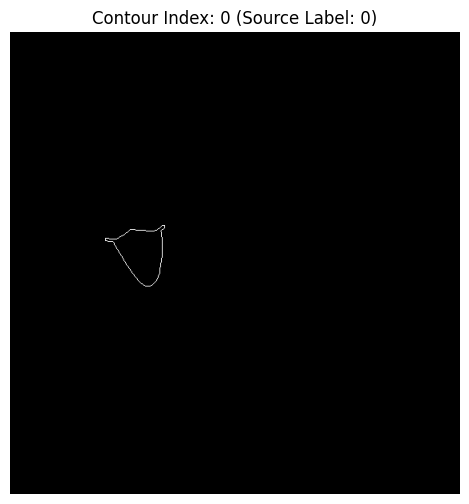

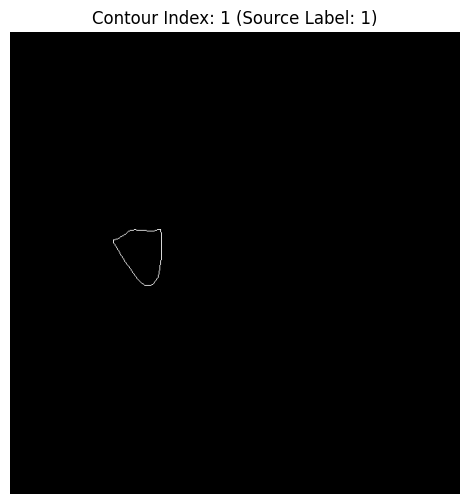

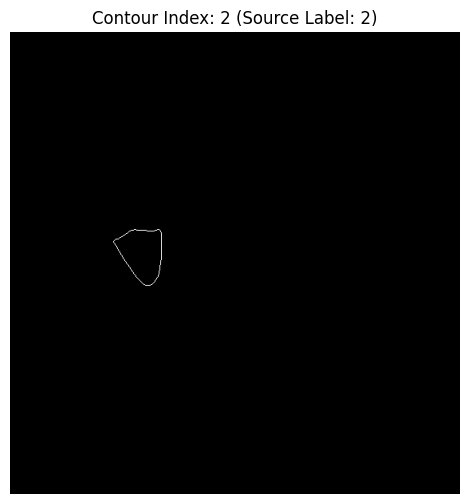

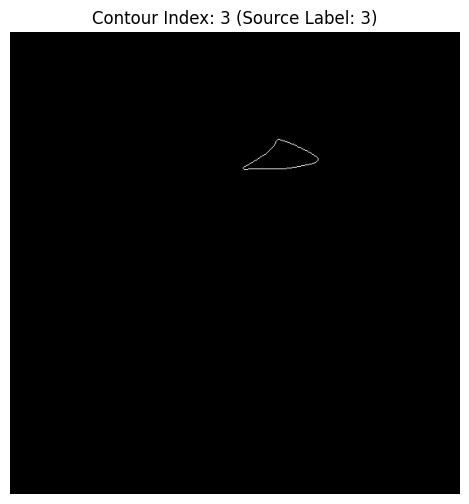

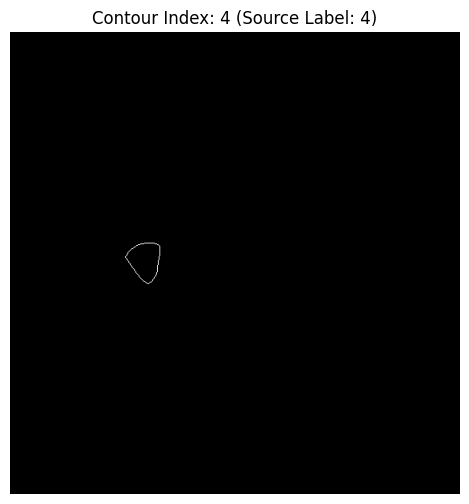

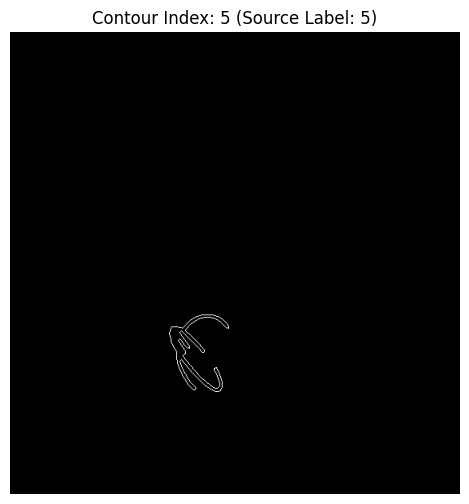

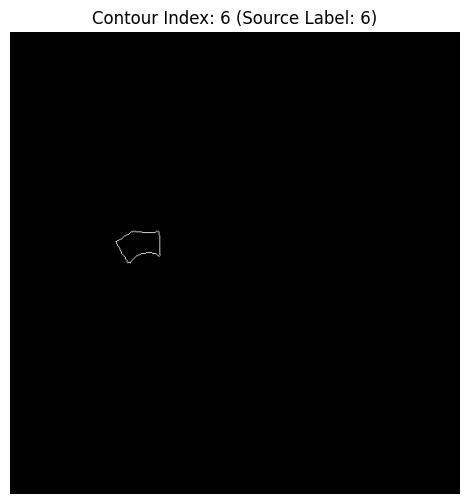

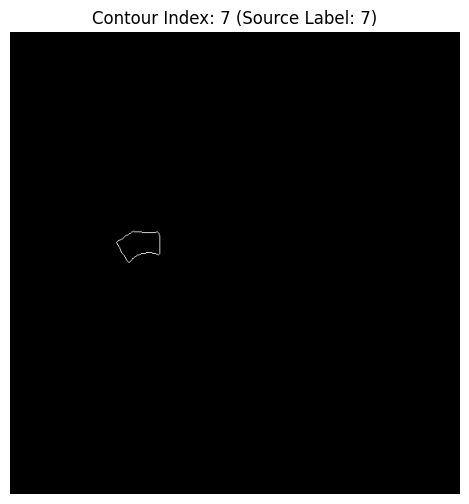

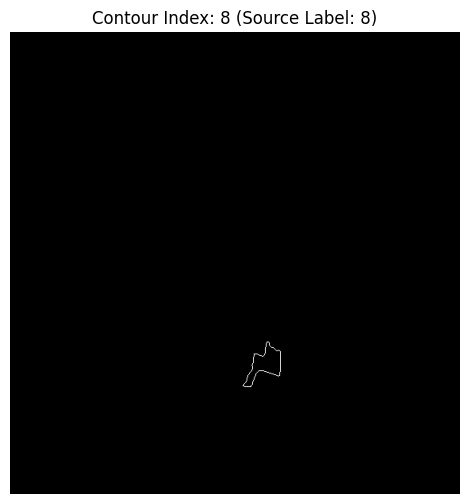

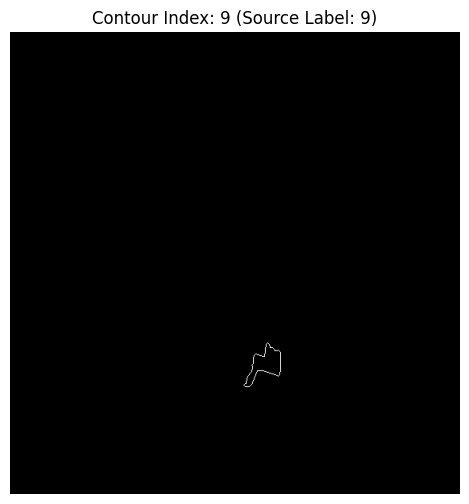

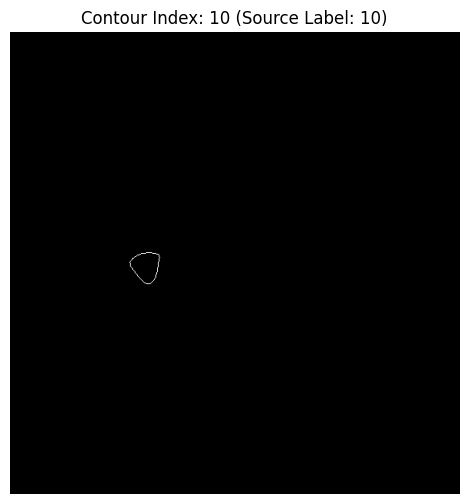

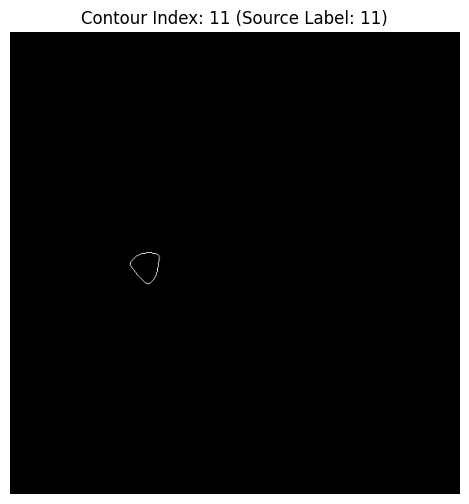

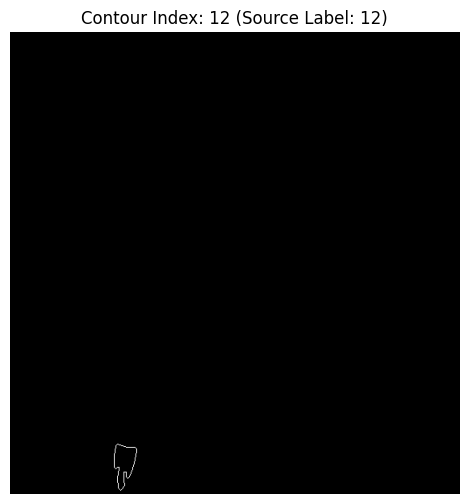

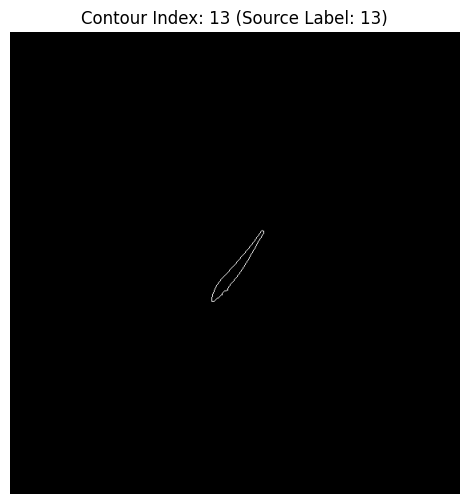

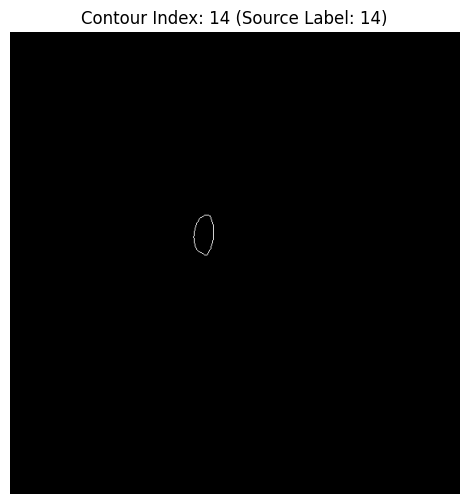

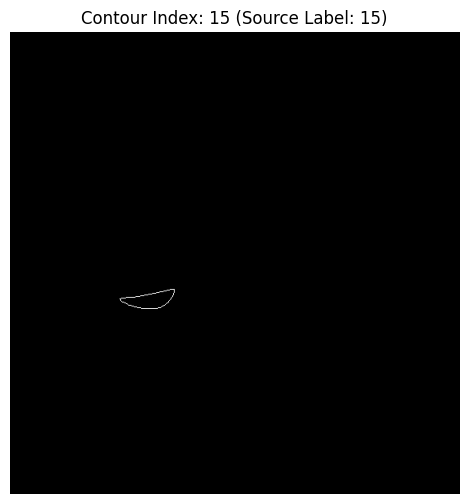

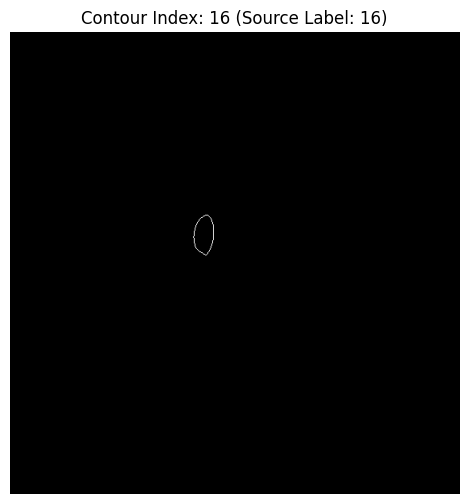

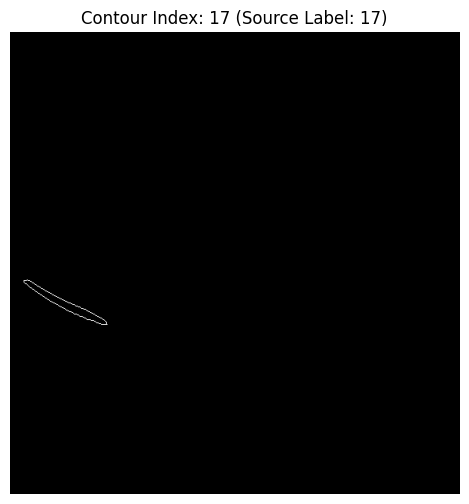

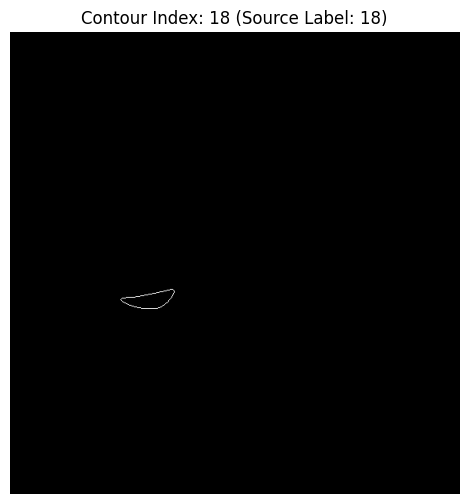

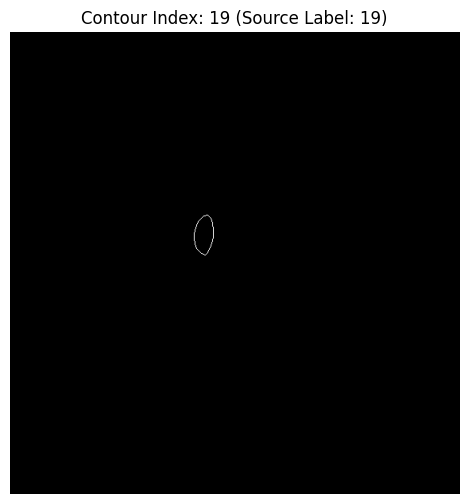

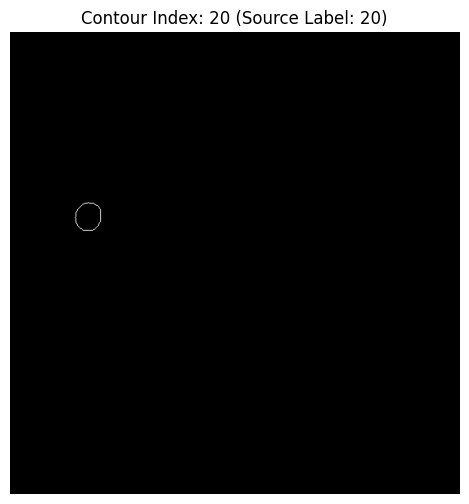

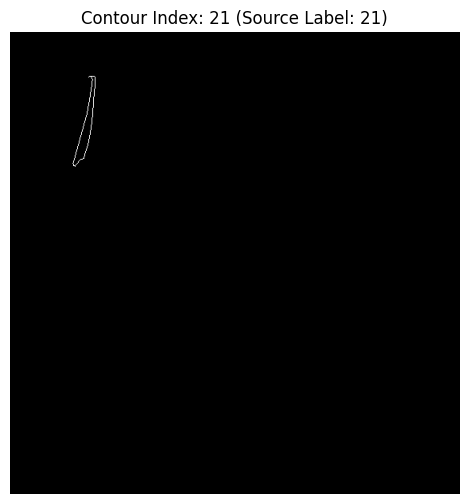

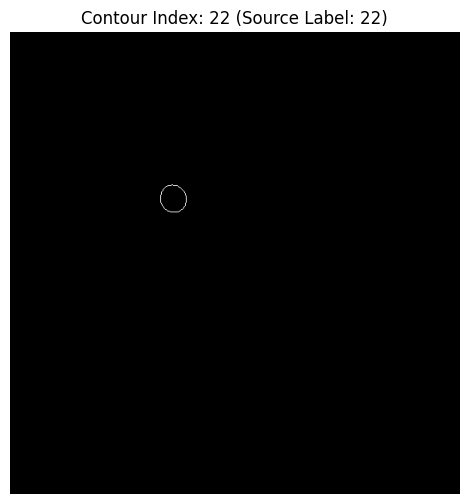

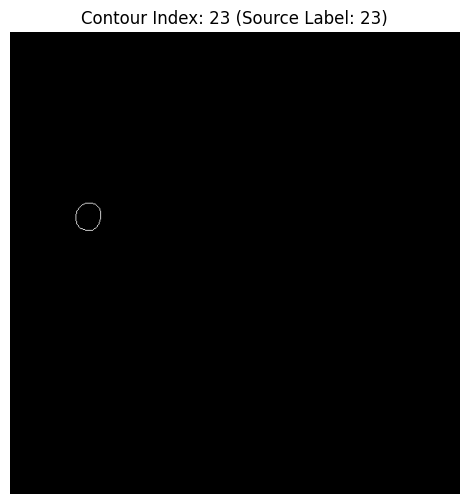

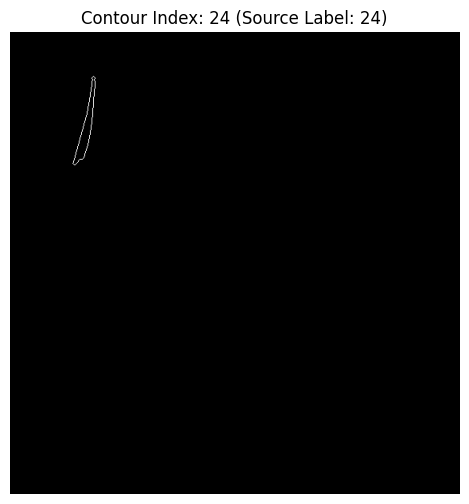

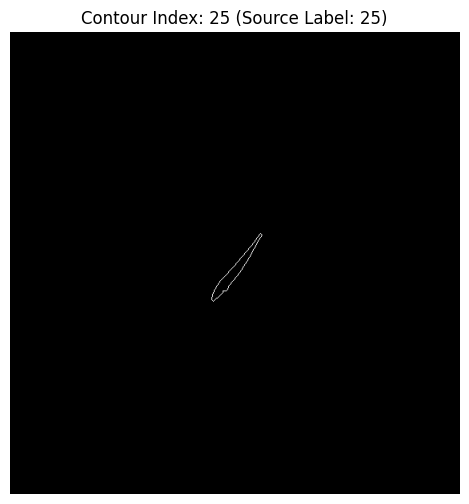

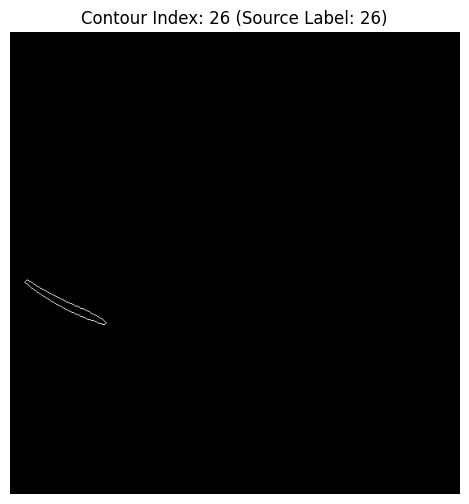

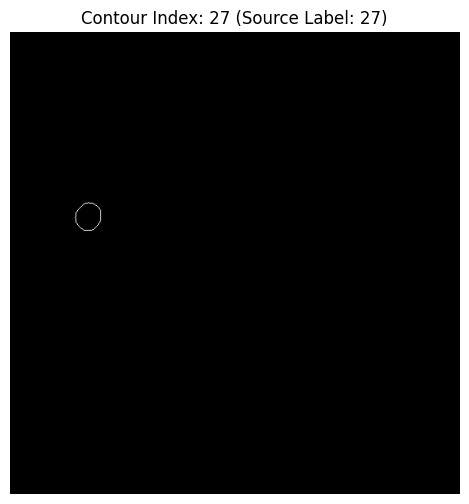

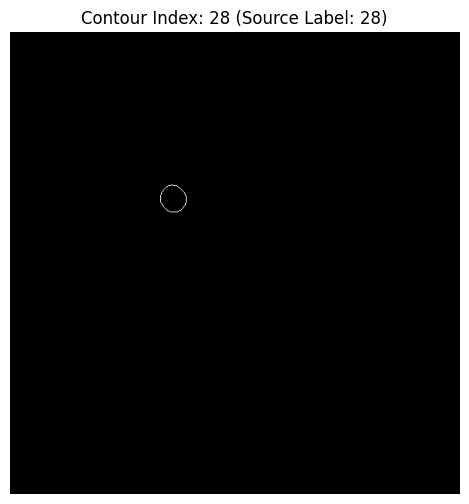

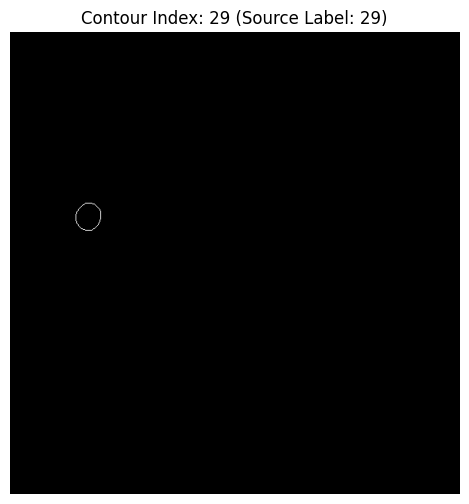

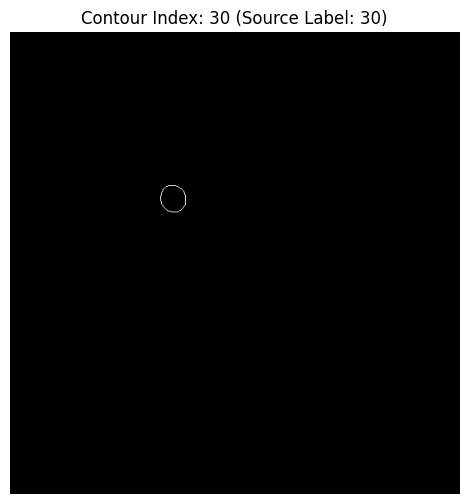

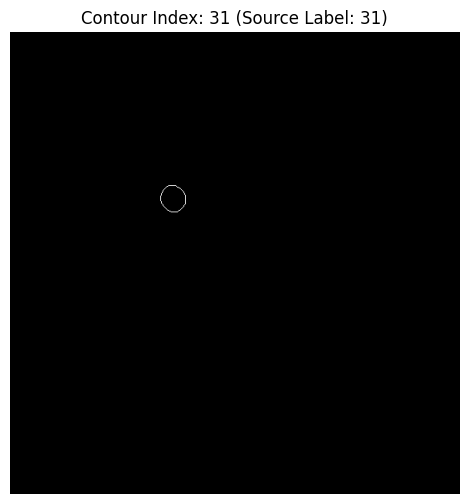

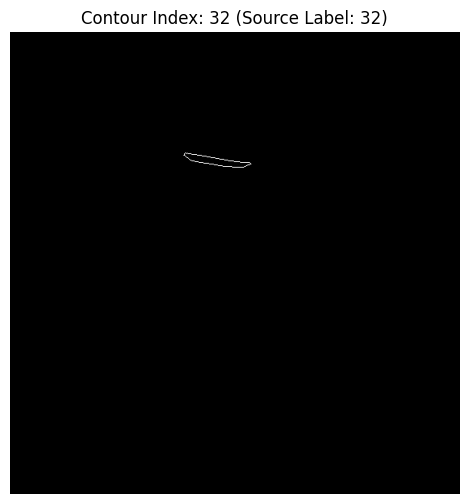

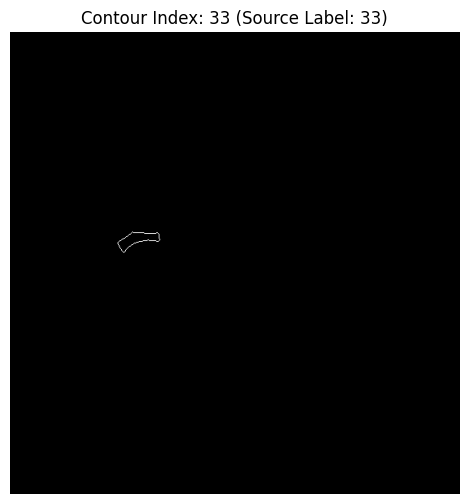

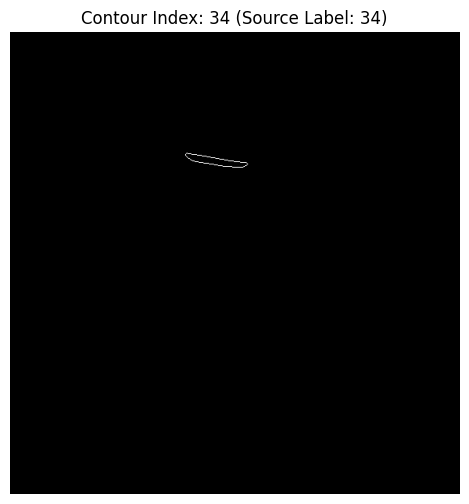

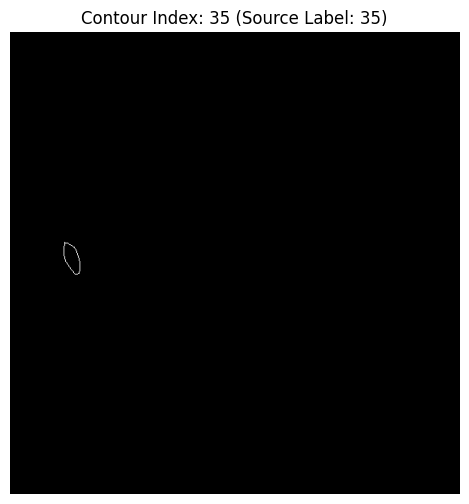

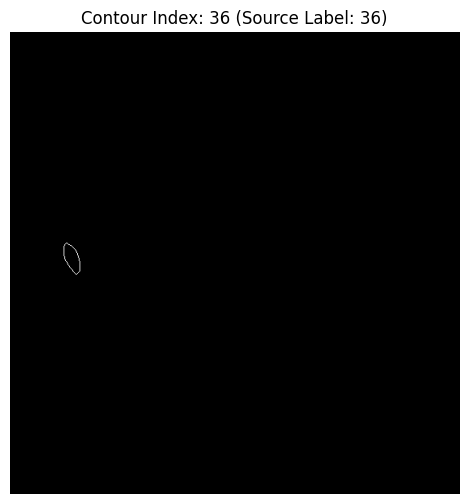

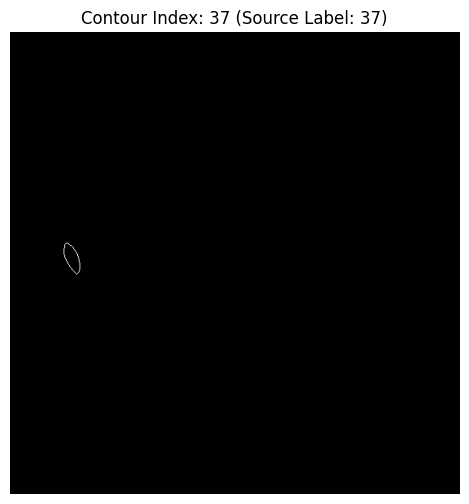

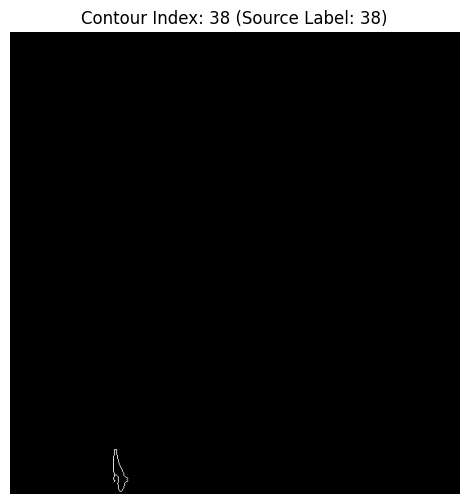

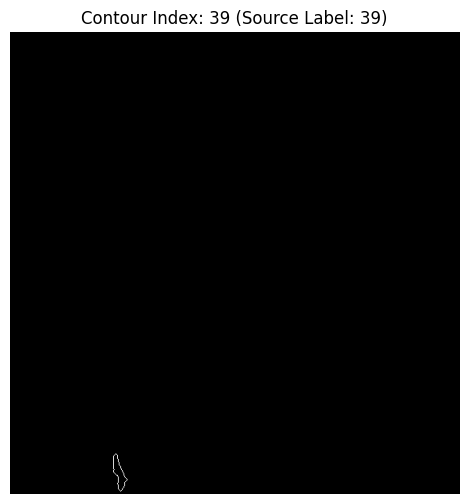

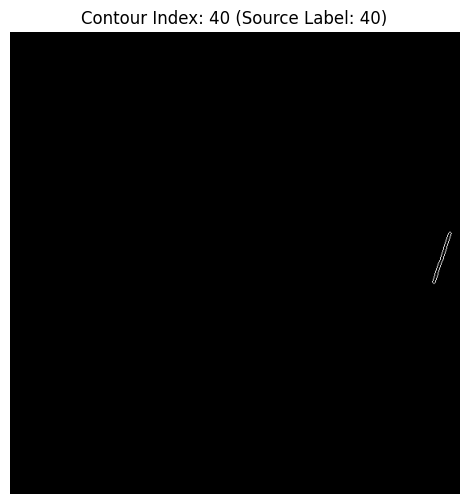

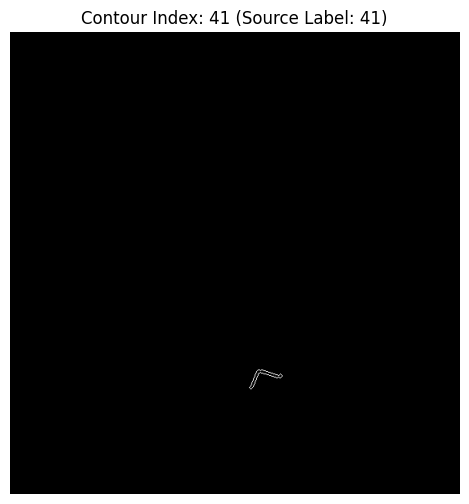

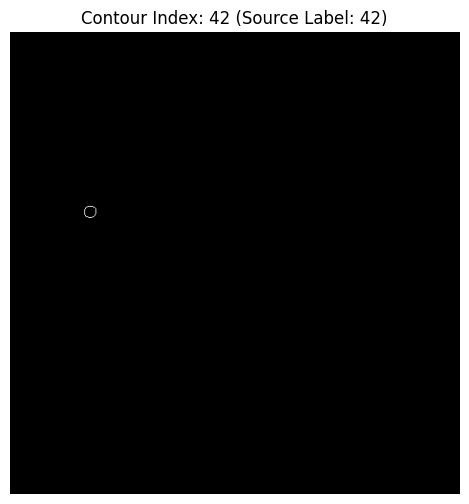

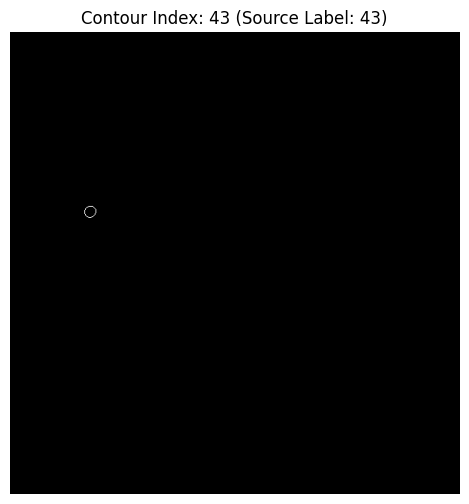

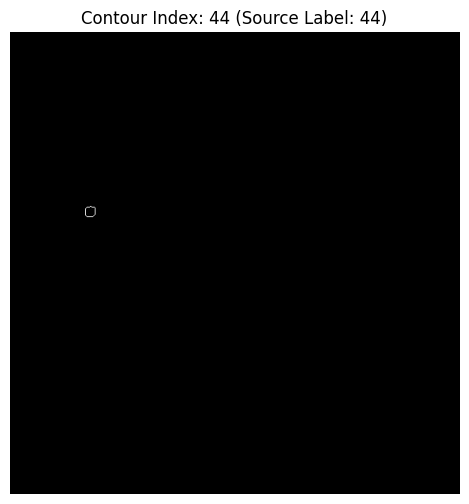

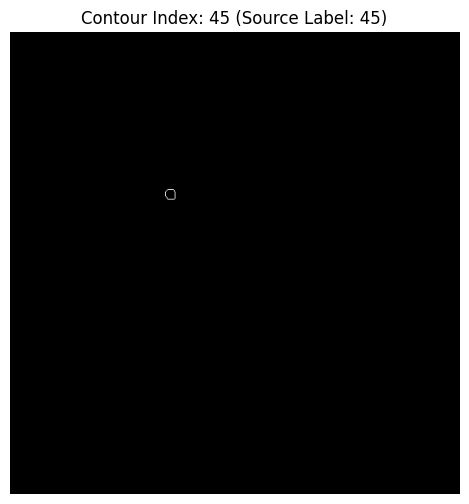

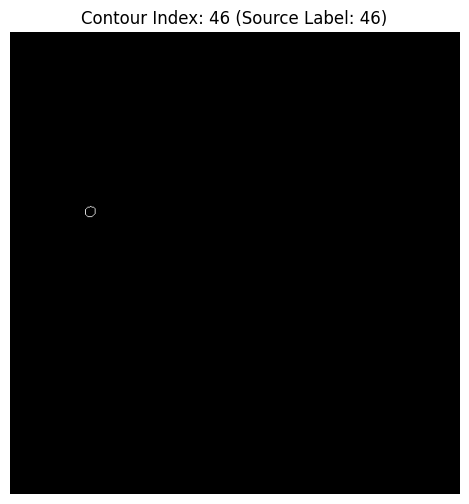

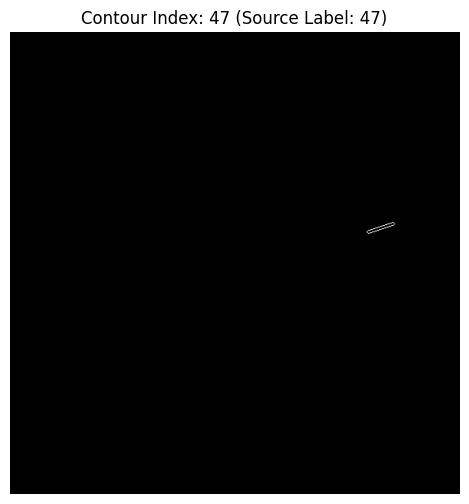

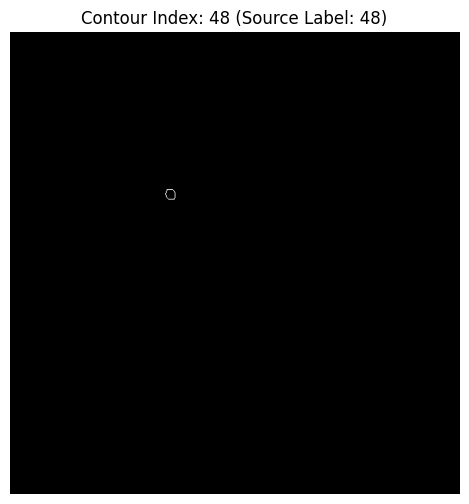

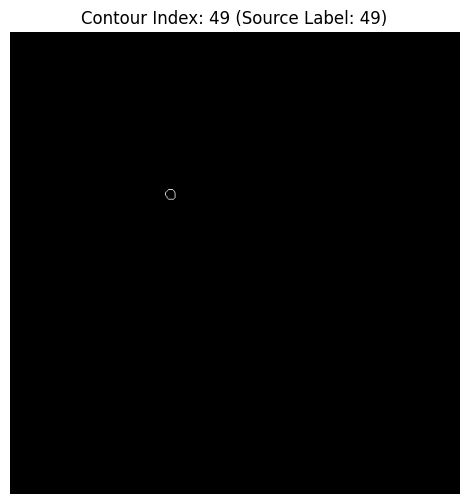

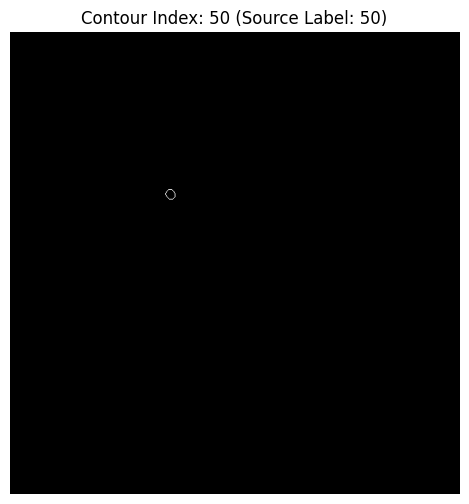

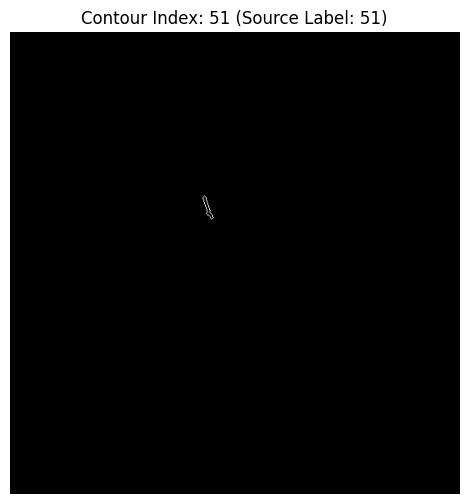

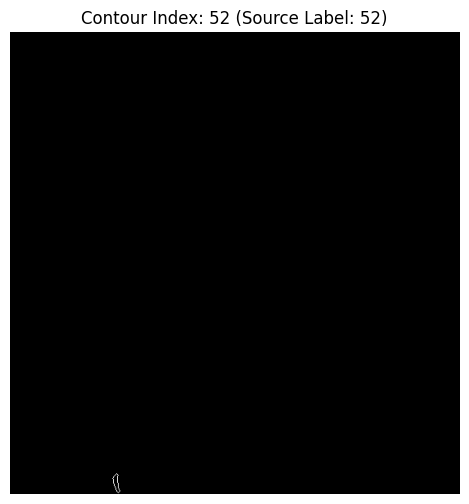

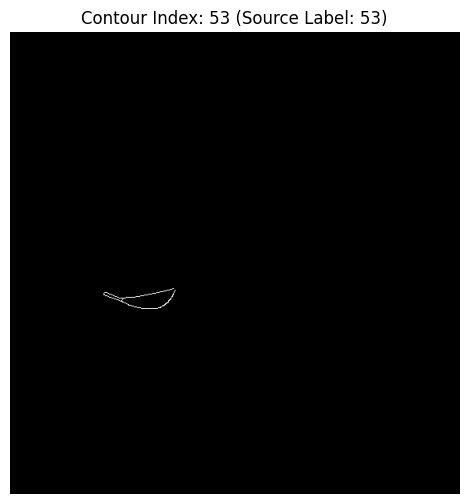

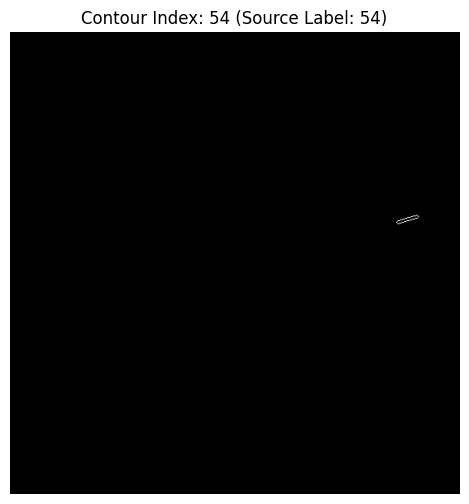

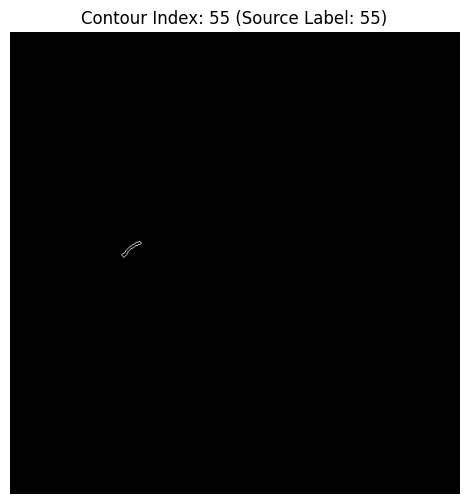

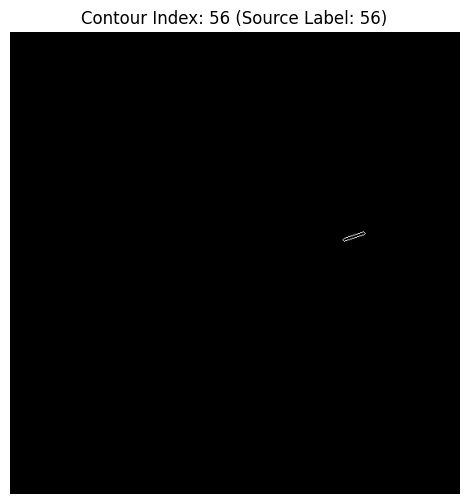

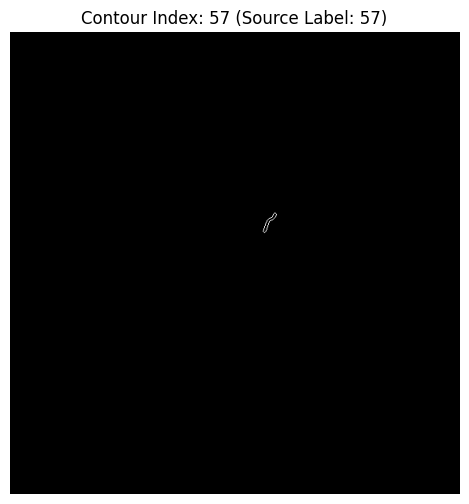

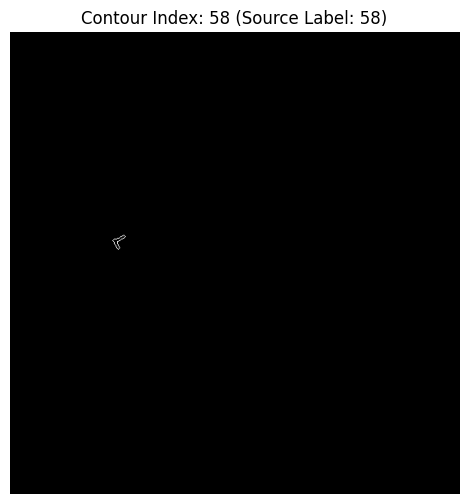

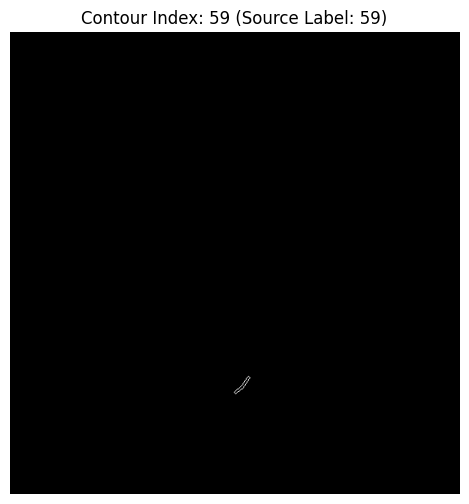

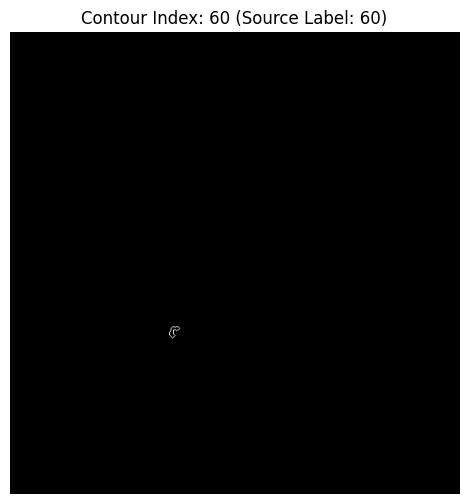

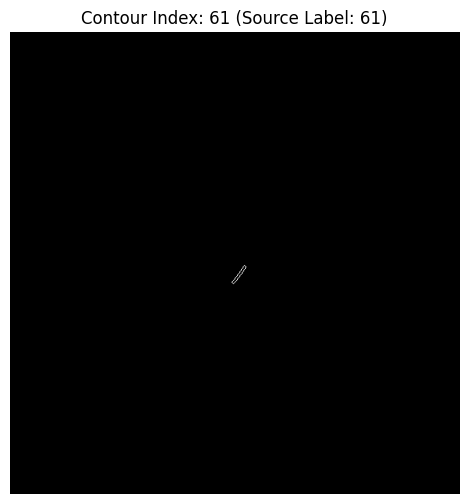

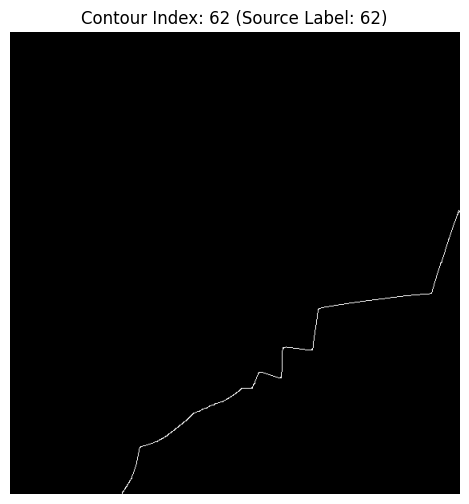

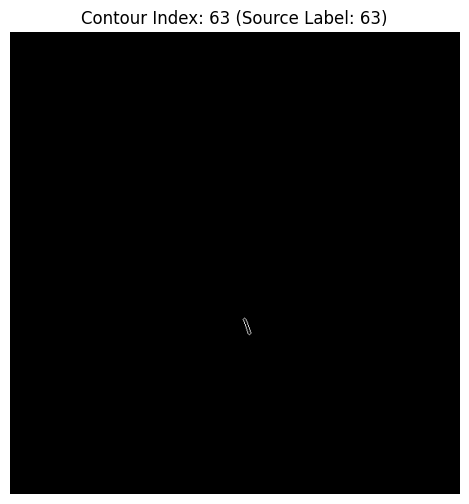

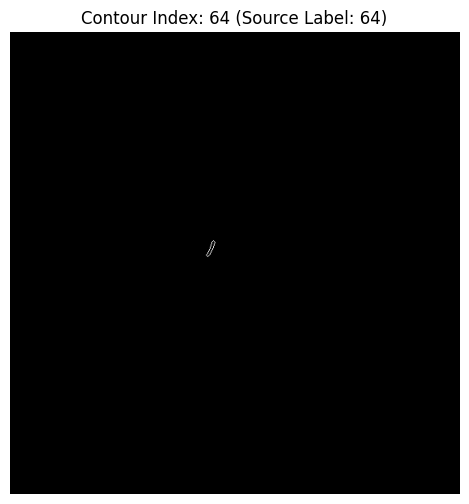

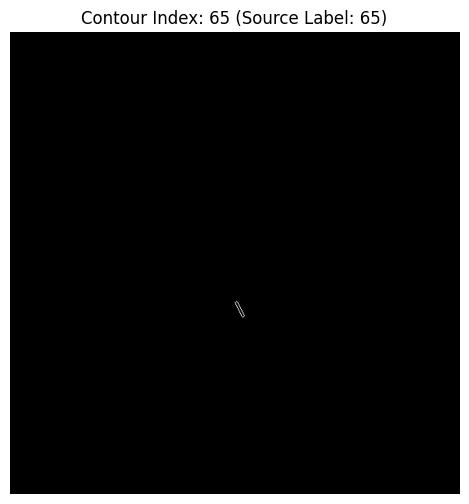

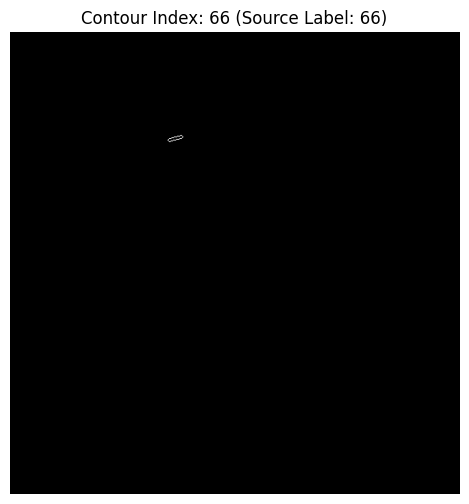

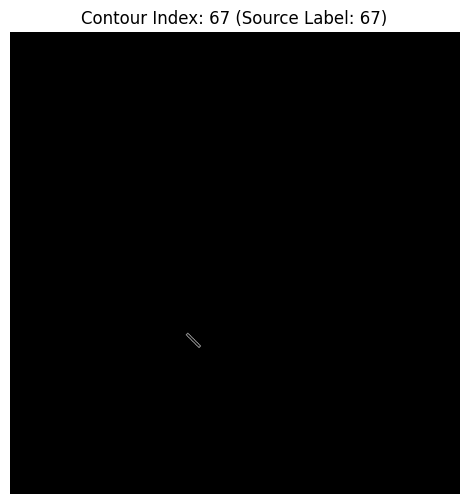

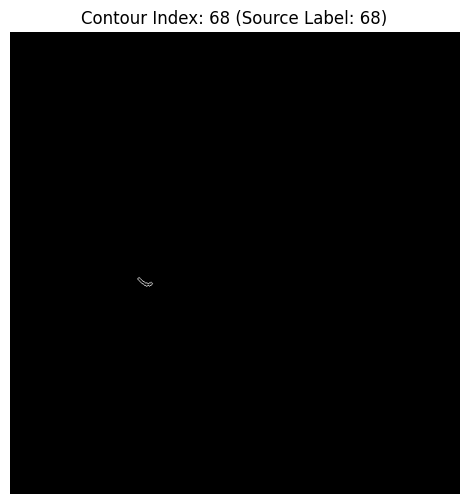

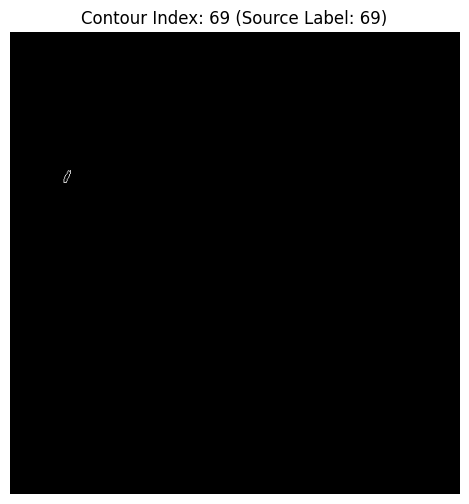

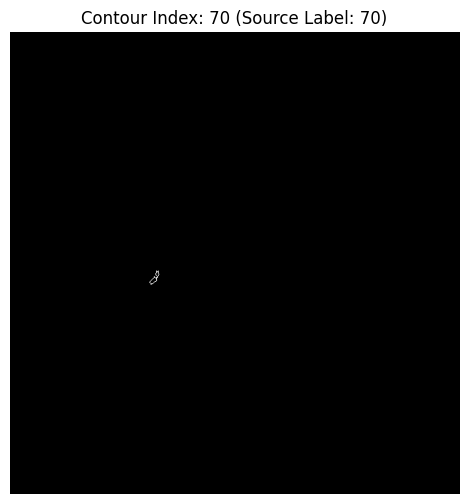

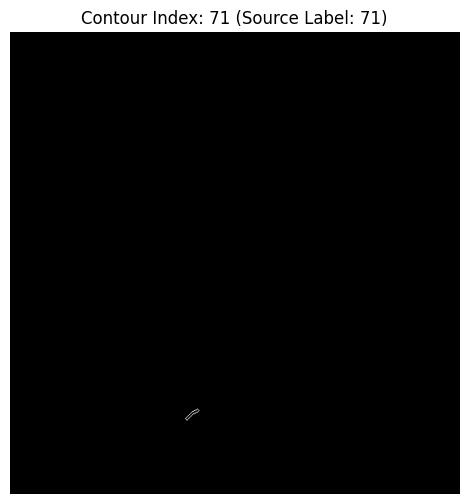

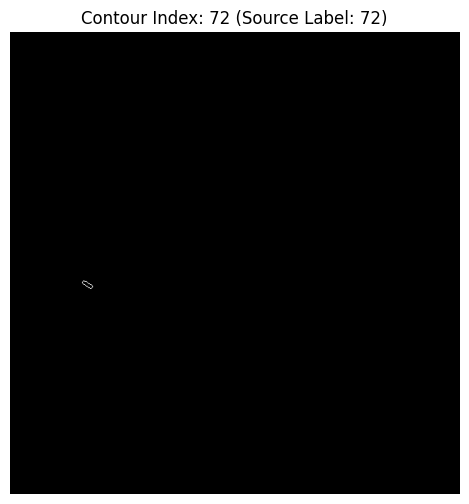

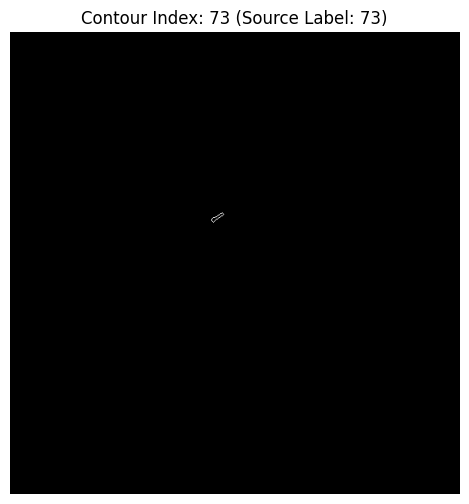

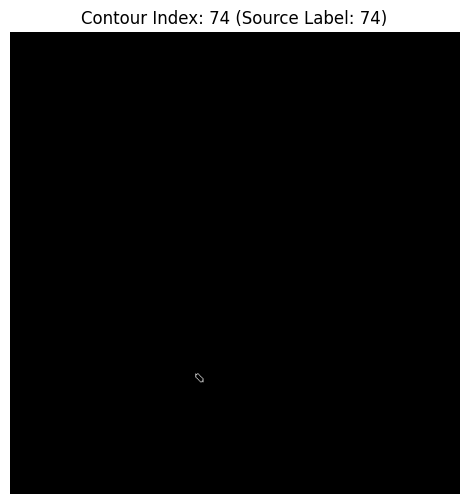

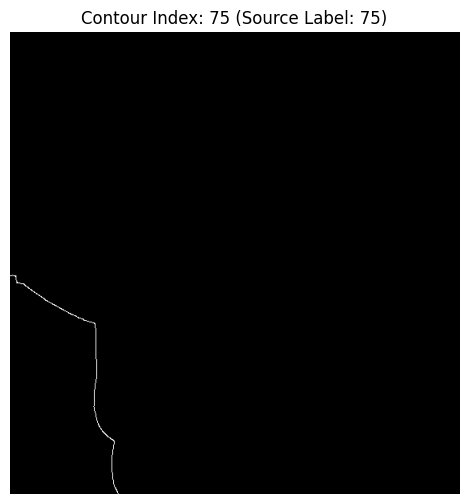

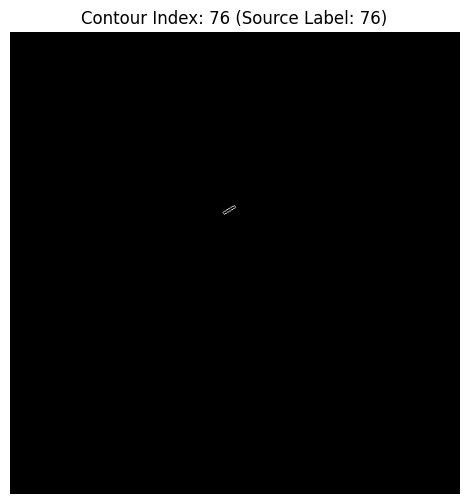

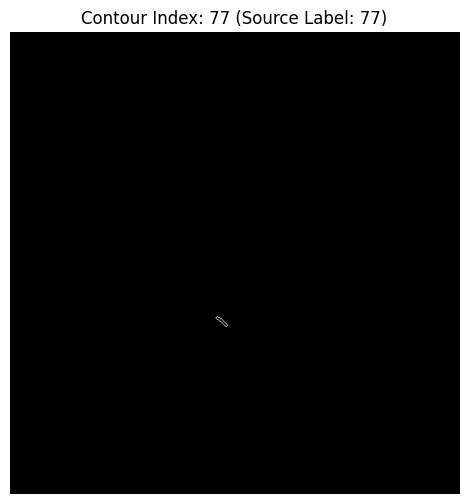

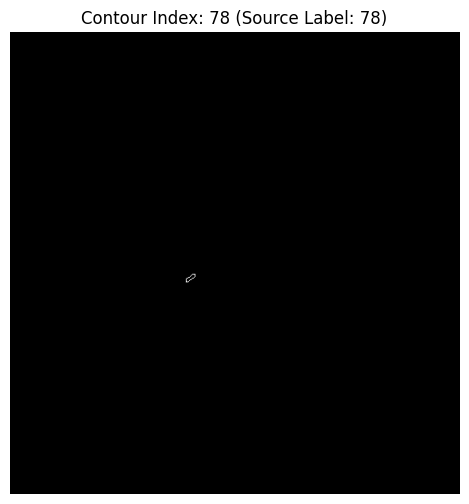

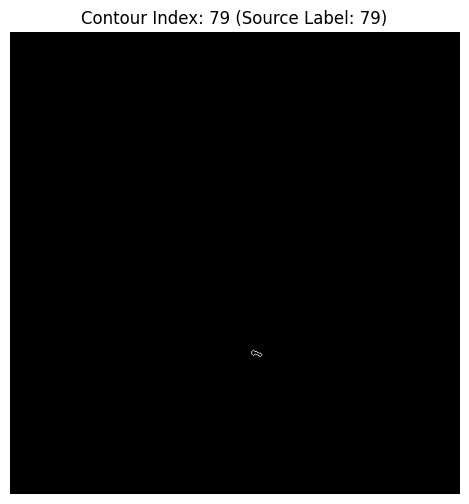

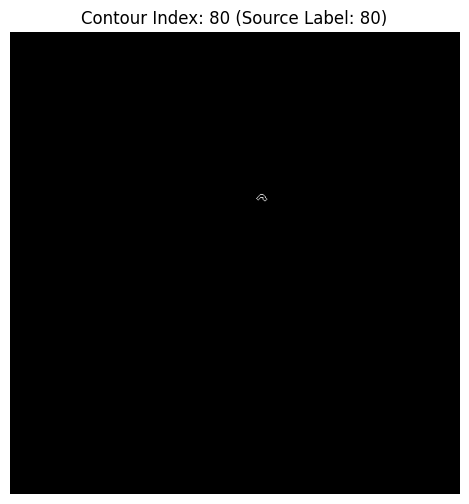

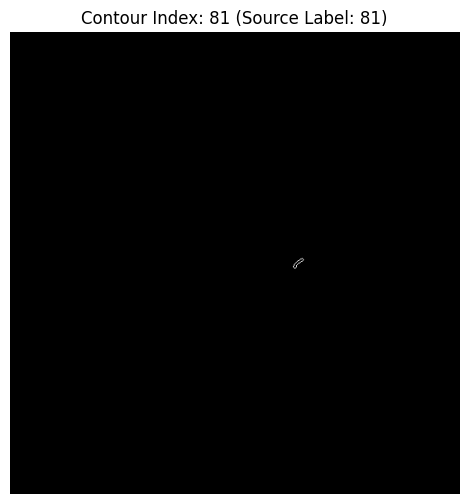

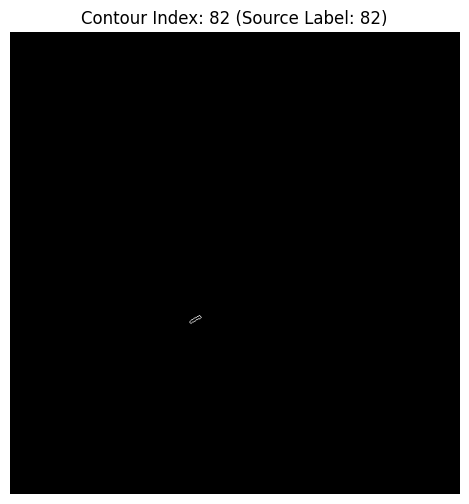

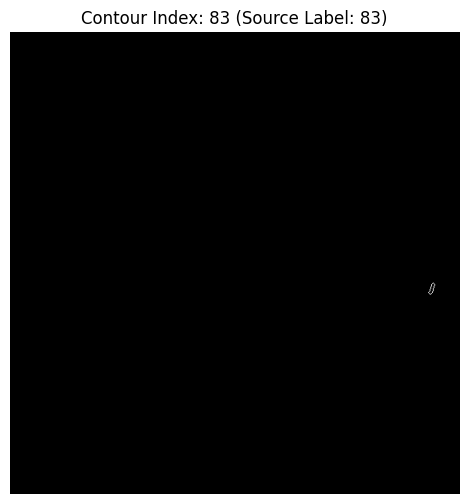

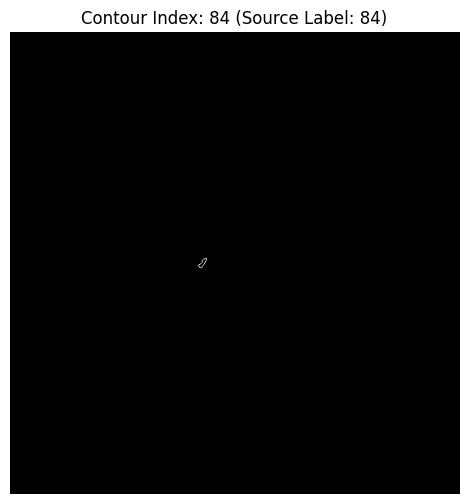

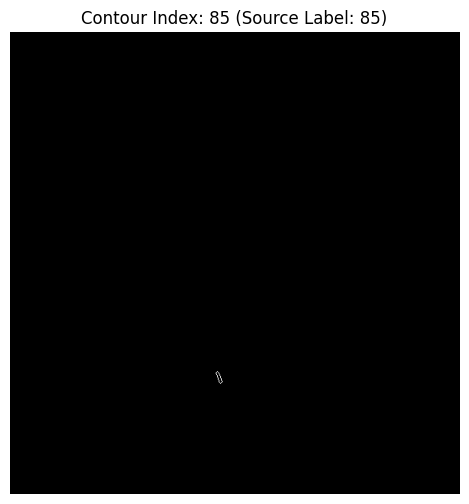

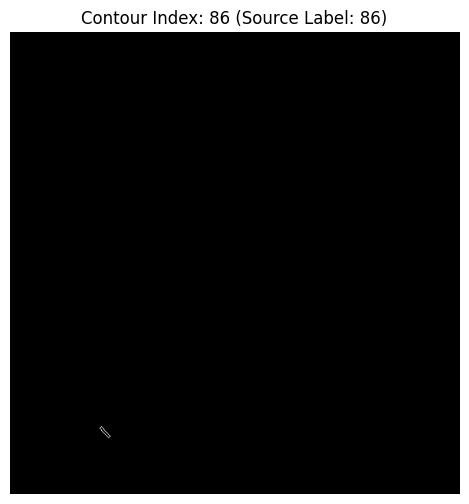

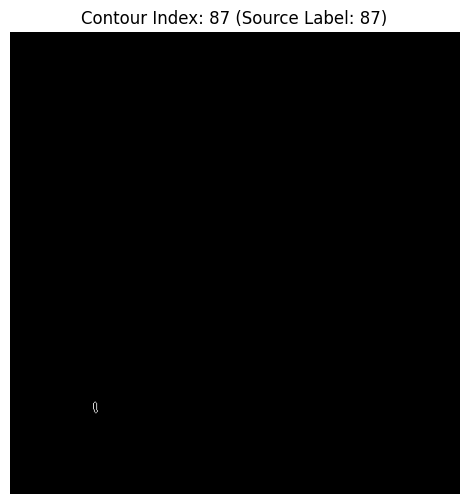

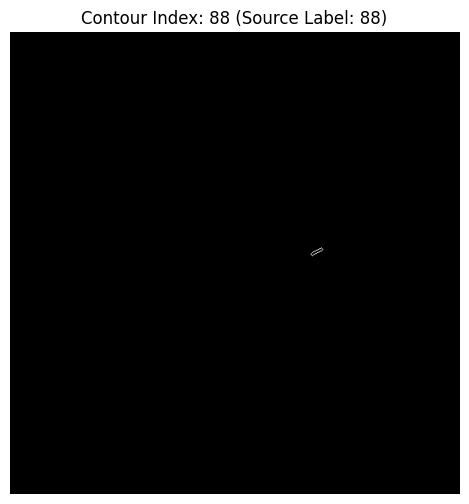

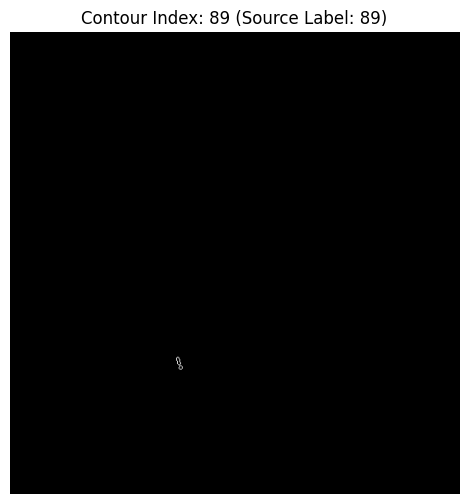

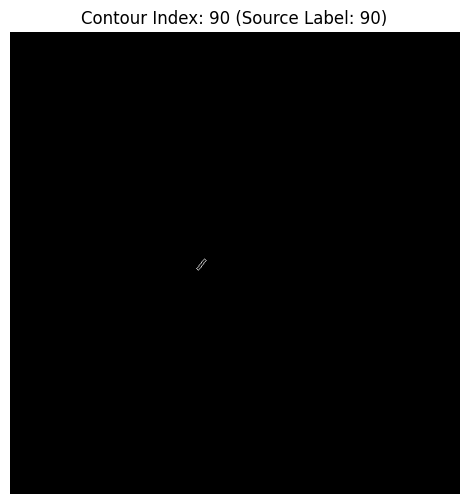

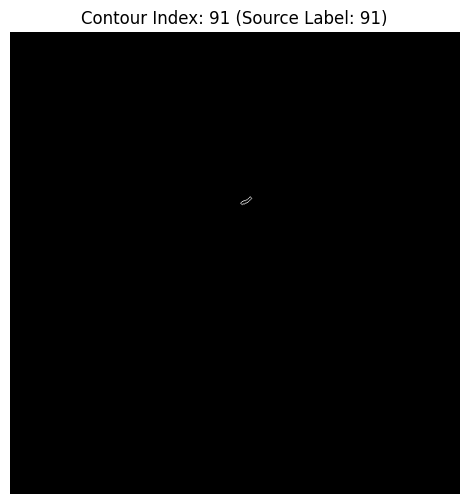

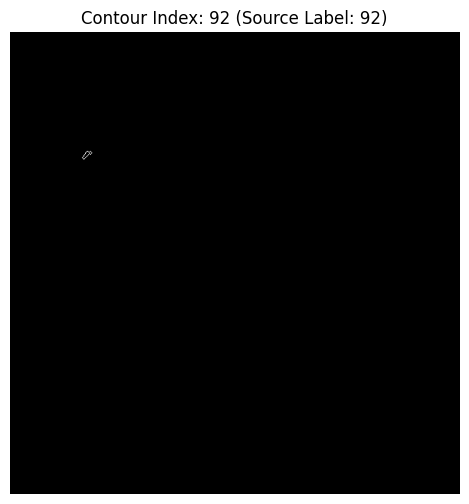

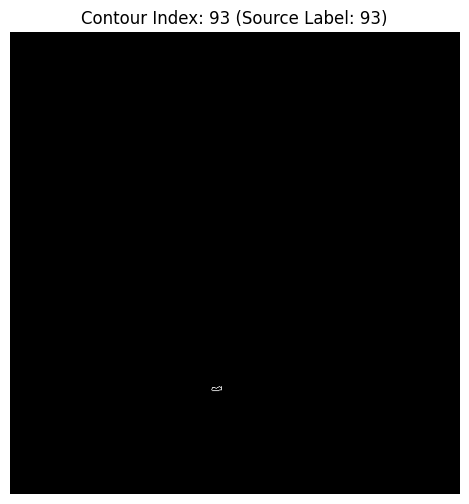

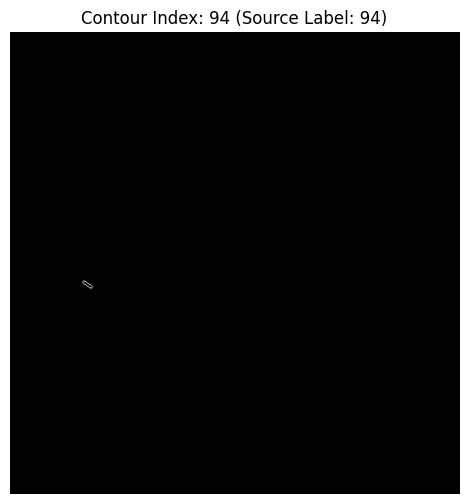

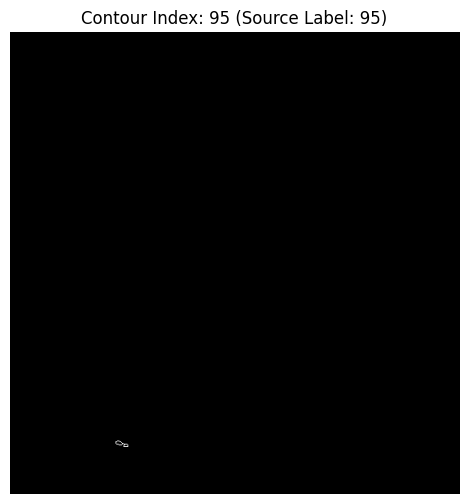

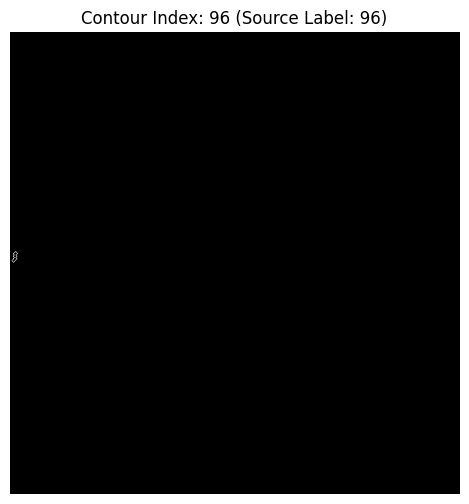

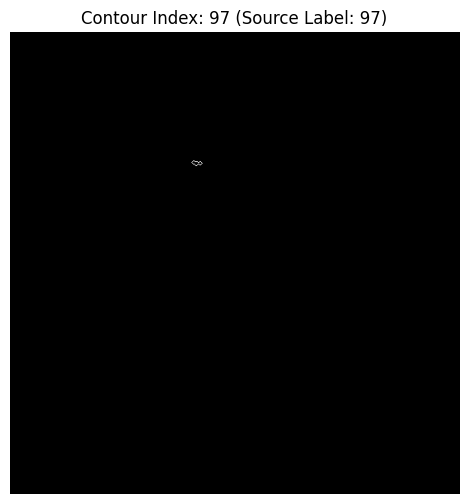

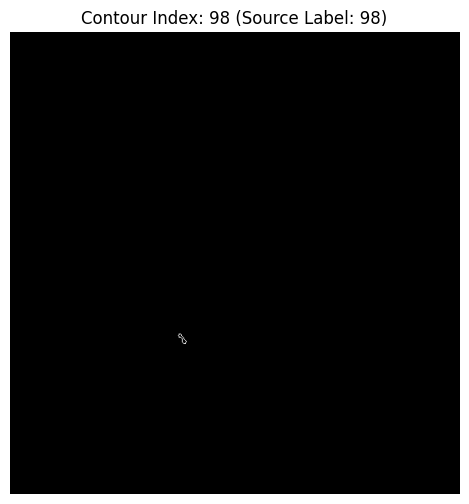

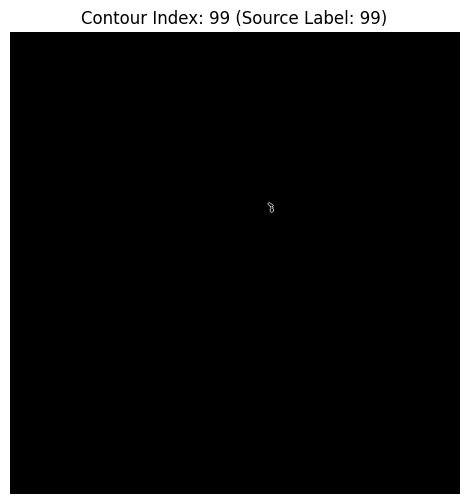

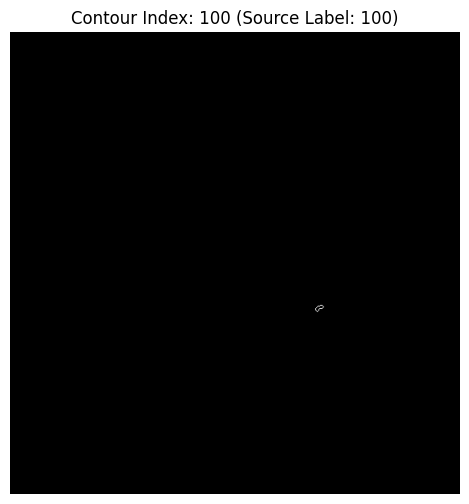

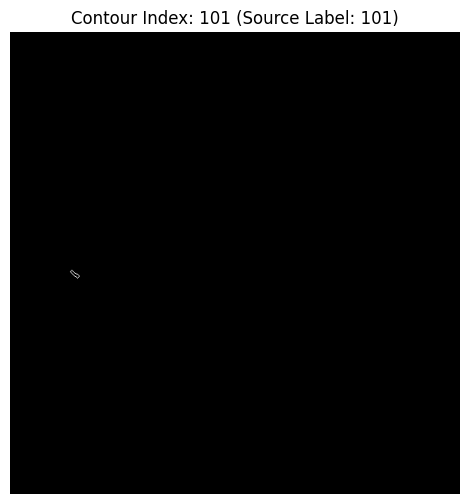

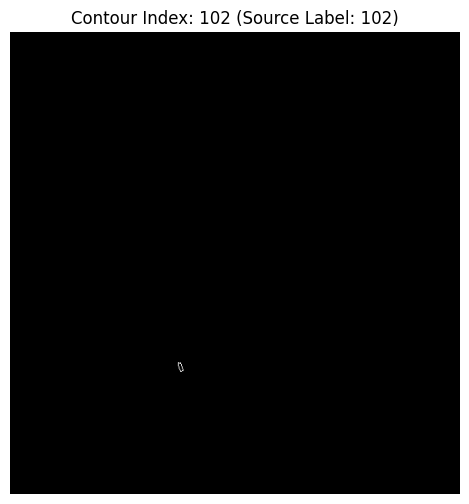

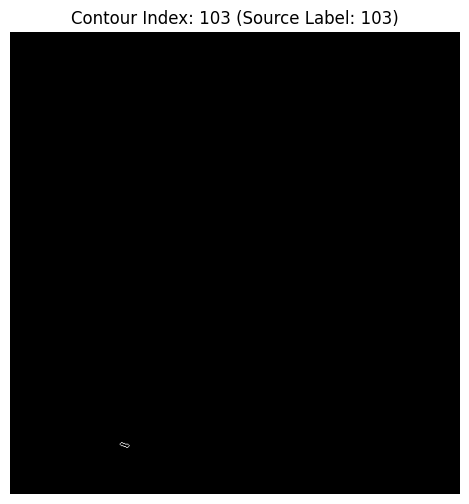

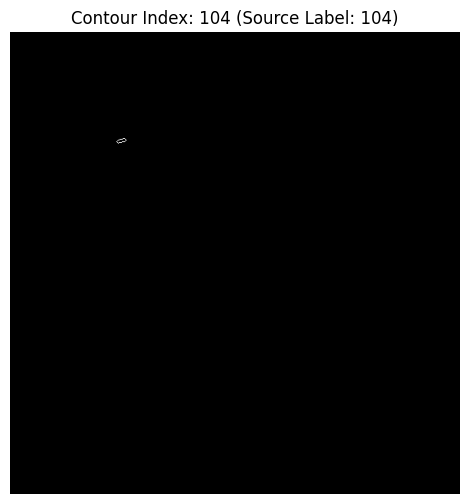

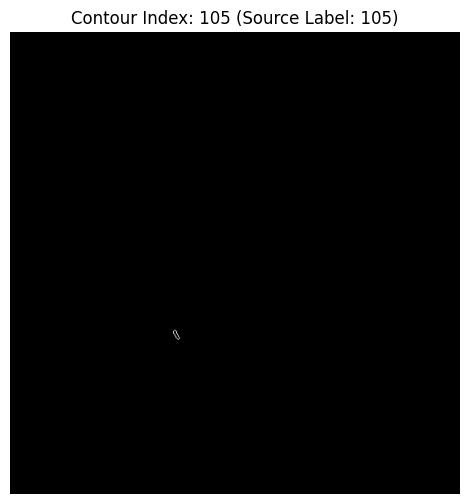

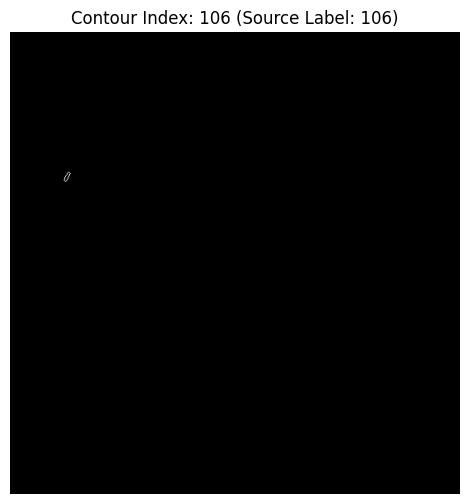

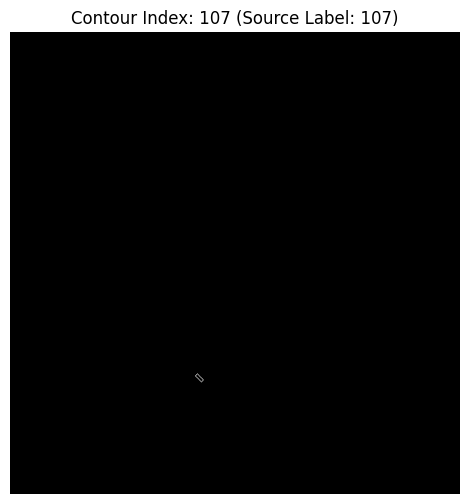

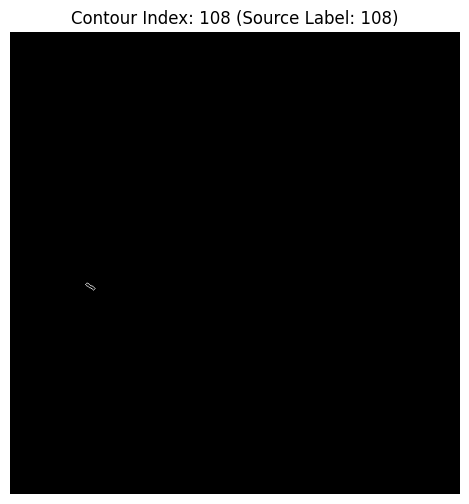

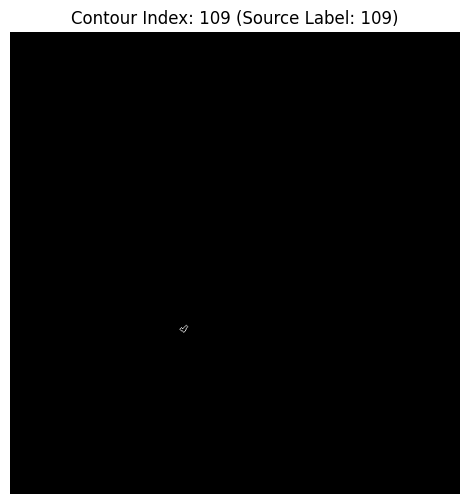

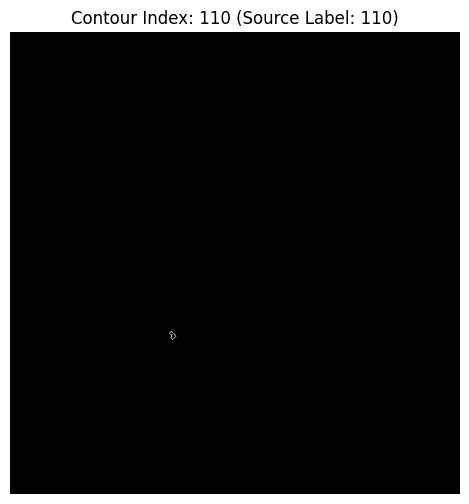

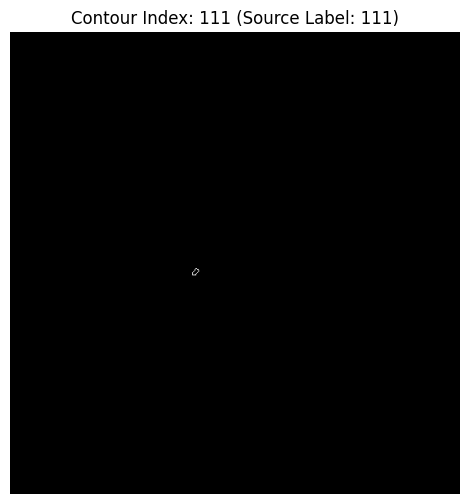

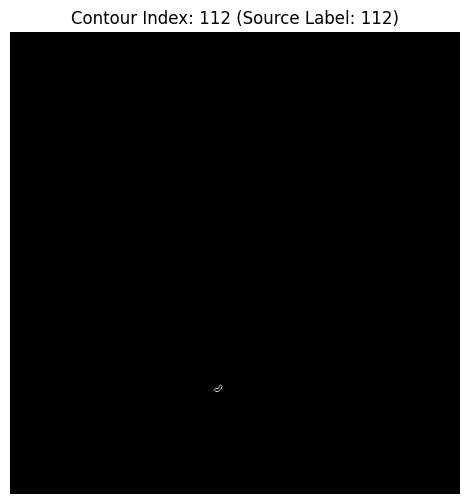

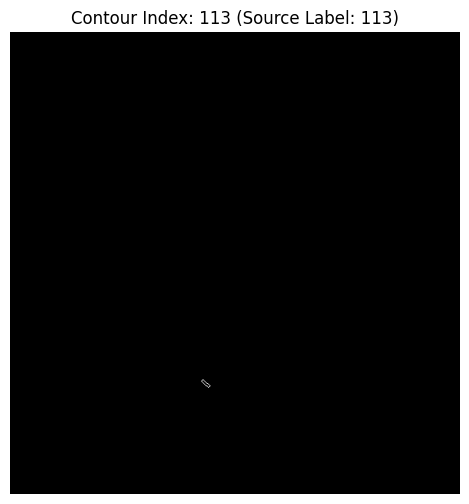

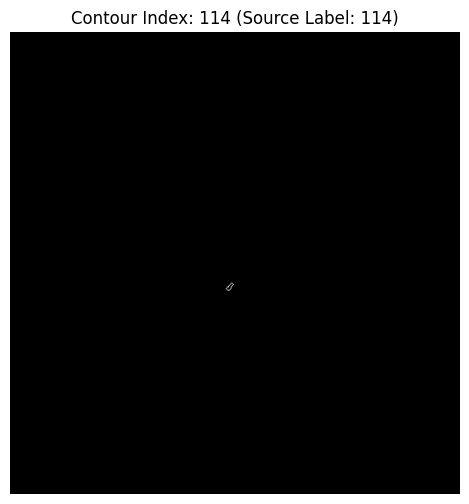

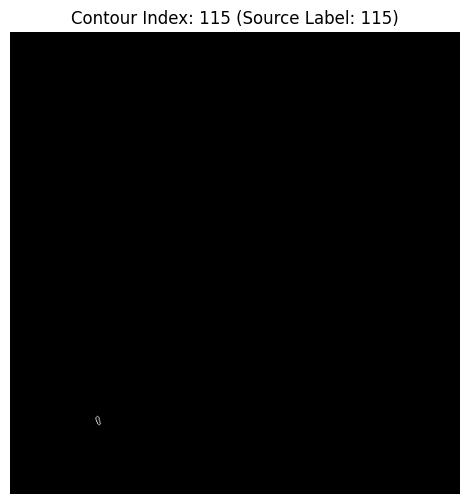

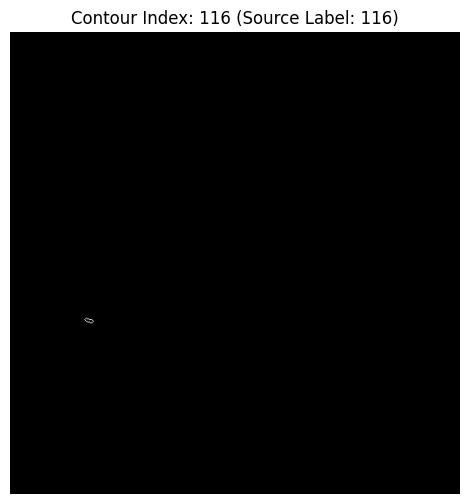

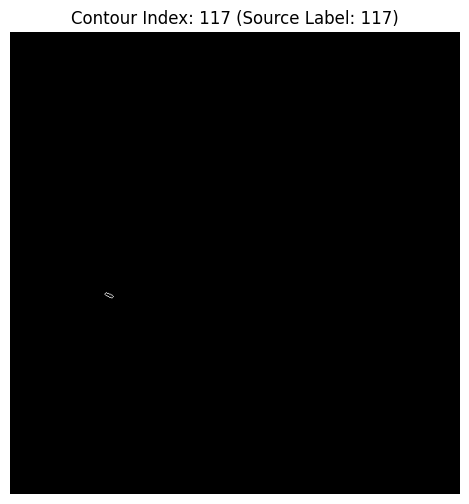

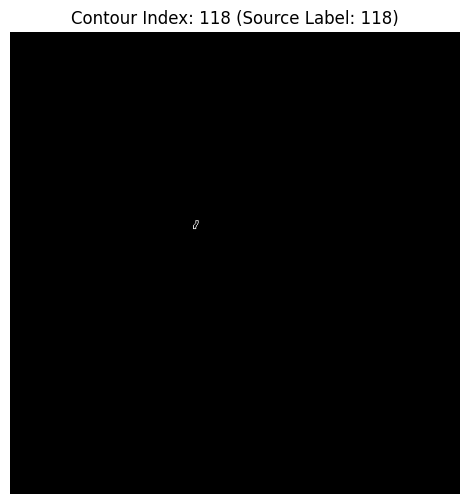

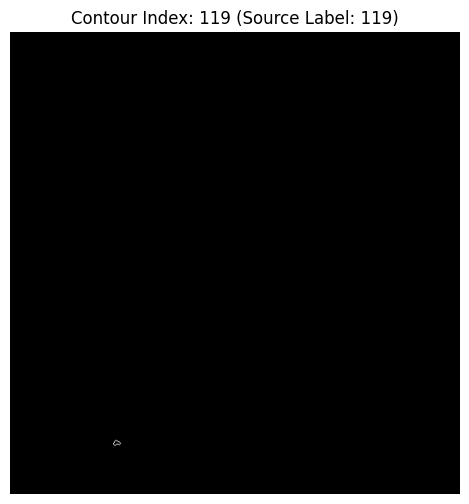

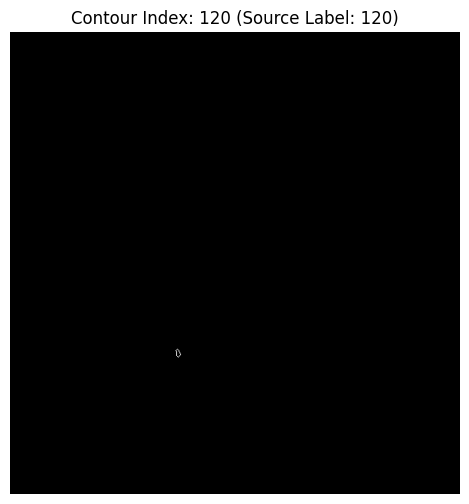


--- Visualizing All Contours Combined ---


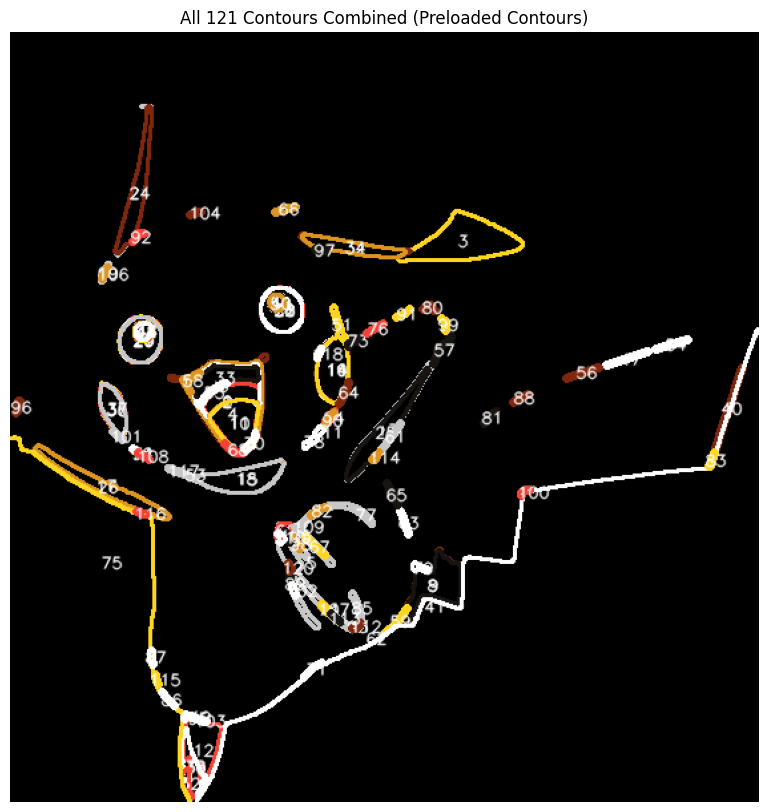

--- Contour Visualization Finished ---


In [112]:
visualize_contours(part2_results["filtered_contours"])